In [2]:
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import cv2
import torch
import sam2
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor as SAM
from lang_sam.models.gdino import GDINO
from PIL import Image

/work/hpc/miniconda3/envs/sam/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/work/hpc/miniconda3/envs/sam/lib/python3.11/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
%set_env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [8]:
def compute_iou(box1, box2):
    """Compute Intersection over Union (IoU) between two xyxy boxes."""
    x1, y1, x2, y2 = box1
    x1_p, y1_p, x2_p, y2_p = box2

    # Compute intersection
    xi1, yi1 = max(x1, x1_p), max(y1, y1_p)
    xi2, yi2 = min(x2, x2_p), min(y2, y2_p)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    # Compute union
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

def non_max_suppression(boxes, iou_threshold=0.5):
    """Prune overlapping bounding boxes using Non-Maximum Suppression (NMS)."""
    if len(boxes) == 0:
        return []

    # Sort boxes by area (largest first)
    boxes = sorted(boxes, key=lambda b: (b[2] - b[0]) * (b[3] - b[1]), reverse=True)
    selected_boxes = []

    while boxes:
        best_box = boxes.pop(0)
        selected_boxes.append(best_box)
        
        boxes = [box for box in boxes if compute_iou(best_box, box) < iou_threshold]

    return selected_boxes

In [4]:
# gdino = GDINO()
sam = SAM(build_sam2("configs/sam2.1/sam2.1_hiera_s.yaml", "/work/hpc/potato/sam/sam2/checkpoints/sam2.1_hiera_small.pt"))

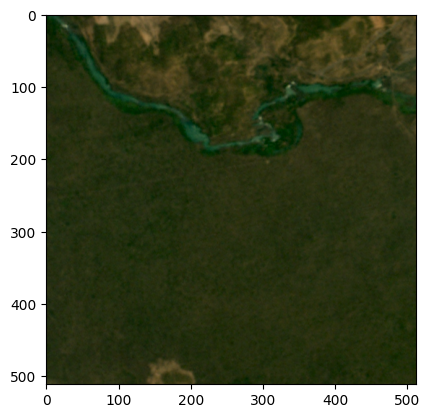

In [5]:
data = cv2.imread("../data/v2/2015.png", cv2.IMREAD_UNCHANGED)
image = data[:, :, :3][..., ::-1]
mask = data[..., 3]
plt.imshow(image[:512, :512])

In [6]:
patch_size = np.array([512, 512])
steps = 64
sampling_shape = mask.shape - patch_size - 1
print(sampling_shape)
x = np.linspace(0, 1, steps)
mesh = np.stack(np.meshgrid(x,x), axis=2).reshape(-1, 2) * sampling_shape
mesh = mesh.astype(int)
print(mesh.max())

[5704 3081]
5704


In [6]:
batch_size=4
threshold = 0.4
text = "waterbody"
boxes = []
box_check = np.zeros([steps, steps])
for i in tqdm.tqdm(range(0, mesh.shape[0], batch_size), desc="Inference on GDINO"):
    inputs = []
    for j in range(i, i+batch_size):
        base = mesh[j]
        inputs.append(Image.fromarray(image[base[0]:base[0] + patch_size[0], base[1]:base[1] + patch_size[1]]))
    prompts = [text] * batch_size
    results = gdino.predict(inputs, prompts, 0.3, 0.25)
    for idx, result in enumerate(results):
        if result['labels']:
            index = i + idx
            x, y = index % steps, index // steps
            box = result['boxes'].cpu().numpy()
            scores = result['scores'].cpu().numpy()
            # print(scores.shape)
            pick = np.where(scores > threshold)[0]
            res = np.concatenate([box[pick], scores[pick][:, None]], axis=1)
            # print(result['scores'].cpu().numpy().max())
            if len(pick) > 0:
                # print(pick)
                box_check[x, y] = scores[pick].min()
                boxes.append(res)
            else: 
                boxes.append([])
    del results

Inference on GDINO:   0%|          | 0/1024 [00:00<?, ?it/s]

Inference on GDINO: 100%|██████████| 1024/1024 [28:06<00:00,  1.65s/it]


In [15]:
valid_boxes = []
for i, box in enumerate(boxes): 
    for b in box:
        c = mesh[i]
        valid_boxes.append([b[0] + c[1], b[1] + c[0], b[2] + c[1], b[3] + c[0]])
valid_boxes = np.array(valid_boxes).astype(int)

In [25]:
pruned = non_max_suppression(valid_boxes, iou_threshold=0.7)
print(len(pruned))
pruned = np.array(pruned)
with open("/work/hpc/potato/airc/data/sam/box_0.5_0.7.npy", "wb") as f:
    np.save(f, pruned)


149


In [19]:
boxes = np.load("/work/hpc/potato/airc/data/sam/box_0.5_0.7.npy")
prune = non_max_suppression(boxes, 0.5)

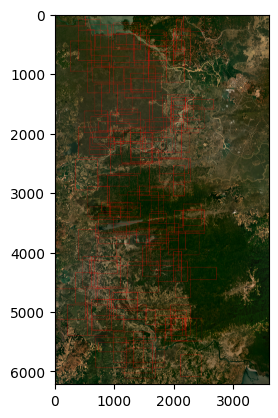

In [20]:
viz  = image.copy()
for box in pruned:
    cv2.rectangle(viz, box[:2], box[2:], (255, 0, 0), 2)
cv2.imwrite("/work/hpc/potato/airc/data/viz/boxes.jpeg", viz[..., ::-1])
plt.imshow(viz)

In [77]:
print(np.array(prune) - np.array([c[1], c[0], c[1], c[0]]))

[[-1124  2082  -612  2594]
 [ -440  2896    72  3408]
 [ -391   813   121  1325]
 [ -342 -1359   170  -847]
 [ -245   180   267   692]
 [ -195  -364   317   148]
 [ -146 -1722   366 -1210]
 [ -146  2805   366  3317]
 [  -97  1176   415  1688]
 [    0 -1269   512  -757]
 [   49  2443   561  2955]
 [   98   451   610   963]
 [   98  1628   610  2140]
 [  146  -635   658  -123]
 [  195 -2265   707 -1753]
 [  196  2896   708  3408]
 [  439  1176   951  1688]
 [  488  -725  1000  -213]
 [  537 -1902  1049 -1390]
 [ -734 -2263  -222 -1754]
 [   -1  -540   511   -34]
 [   48 -1630   560 -1124]
 [  -49     0   463   505]
 [    0  2991   512  3496]
 [ -196  -887   315  -395]
 [ -513  1539   -27  2051]
 [  816  -996  1294  -538]
 [ -146 -2386   312 -1935]
 [ -917  2353  -517  2865]
 [  635  -110  1147   288]
 [  783  1126  1295  1512]
 [  831  2576  1343  2961]
 [  880   765  1392  1149]
 [ -455 -1359   -75  -847]
 [  684 -1177  1196  -798]
 [  831 -1136  1343  -757]
 [ -734 -2446  -366 -1934]
 

In [88]:
def find_boxes(boxes, base, size, minArae=0.3):
    minArea = 0.3 * size[0] * size[1]
    dst = base + size
    window = np.array([base[1], base[0], base[1], base[0]])
    cand = boxes - window
    valid = np.where(cand < 0, 0, cand)
    for i in range(size.shape[0]):
        valid[:, i] = np.where(valid[:, i] > size[i], size[i], valid[:, i])
        j = i + 2
        valid[:, j] = np.where(valid[:, j] > size[i], size[i], valid[:, j])
    # print(valid, base, window)
    checked = [box for box in valid if max(box[2] - box[0], 0) * max(box[3] - box[1], 0) >= minArea]
    return sorted(checked, key=lambda box: -max(box[2] - box[0], 0) * max(box[3] - box[1], 0))


2 [array([  0,   0, 463, 505]), array([  0, 180, 267, 512])]
2


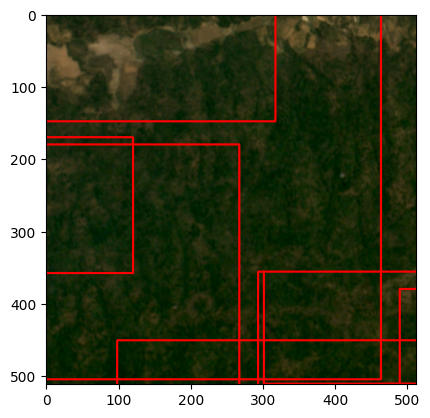

In [89]:
c = mesh[1500]
valid = find_boxes(np.array(prune), c, patch_size, minArae=0.3)
print(len(valid), valid)
plt.imshow(viz[c[0]:c[0] + 512, c[1]:c[1] + 512])
post_box = non_max_suppression(valid, 0.7)
print(len(post_box))

In [95]:
sigmoid = lambda x: 1 /(1 + np.exp(-x))
o_weights = np.full(mask.shape, 1e-3)
o_scores = np.full(mask.shape, 0.5) * o_weights
o_logits = np.zeros(mask.shape, dtype=float)
kernel = np.zeros(patch_size, dtype=float)
kernel[255, 255] = 100
kernel = cv2.GaussianBlur(kernel, (0, 0), 200, 200)
kernel /= kernel.max()

null_thresh = 0.85
pos_threshold = 0.25
for i in tqdm.tqdm(range(mesh.shape[0]), desc="SAM Inference"):
    c = mesh[i]
    dst = c + patch_size
    input_score = (o_scores / o_weights)[c[0]:dst[0], c[1]:dst[1]]
    input_mask = (o_logits / o_weights)[c[0]:dst[0], c[1]:dst[1]]
    print(input_score.min())
    input_mask = np.where(input_mask > input_score, 1, 0).astype(np.uint8)
    input_mask = cv2.resize(input_mask, (256, 256))
    boxis = find_boxes(prune, c, patch_size, minArae=0.3)
    # Get biggest box
    post_box = non_max_suppression(valid, 0.6)[0]
    patch = Image.fromarray(image[c[0]:dst[0], c[1]:dst[1]])
    sam.set_image(patch)
    masks, scores, logits = sam.predict(box=post_box, mask_input=input_mask[None, :], multimask_output=False, return_logits=True)
    mask, score, logit = masks[0], scores[0], logits[0]
    if score < pos_threshold or np.mean(mask) > null_thresh:
        print("Skip this frame")
        o_weights[c[0]:dst[0], c[1]:dst[1]] += kernel * score
        o_scores[c[0]:dst[0], c[1]:dst[1]] = input_score * o_weights[c[0]:dst[0], c[1]:dst[1]]
    else:
        logit = cv2.resize(logit, patch_size)
        logit = sigmoid(logit)
        w = kernel * score 
        o_logits[c[0]:dst[0], c[1]:dst[1]] += logit * w
        o_weights[c[0]:dst[0], c[1]:dst[1]] += w  
        o_scores[c[0]:dst[0], c[1]:dst[1]] += score * w        
    
    


SAM Inference:   0%|          | 0/4096 [00:00<?, ?it/s]

0.5


SAM Inference:   0%|          | 1/4096 [00:02<2:32:27,  2.23s/it]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   0%|          | 2/4096 [00:04<2:29:54,  2.20s/it]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   0%|          | 3/4096 [00:08<3:21:21,  2.95s/it]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   0%|          | 4/4096 [00:10<3:05:19,  2.72s/it]

(1, 512, 512)
0.3753826851549944


SAM Inference:   0%|          | 5/4096 [00:14<3:31:43,  3.11s/it]

(1, 512, 512)
0.48210271998888765


SAM Inference:   0%|          | 6/4096 [00:16<3:17:04,  2.89s/it]

(1, 512, 512)
0.5


SAM Inference:   0%|          | 7/4096 [00:18<2:57:53,  2.61s/it]

(1, 512, 512)
0.5


SAM Inference:   0%|          | 8/4096 [00:20<2:42:18,  2.38s/it]

(1, 512, 512)
0.5


SAM Inference:   0%|          | 9/4096 [00:23<2:57:57,  2.61s/it]

(1, 512, 512)
0.5


SAM Inference:   0%|          | 10/4096 [00:26<3:01:23,  2.66s/it]

(1, 512, 512)
0.5


SAM Inference:   0%|          | 11/4096 [00:31<3:52:06,  3.41s/it]

(1, 512, 512)
0.5


SAM Inference:   0%|          | 12/4096 [00:35<3:51:42,  3.40s/it]

(1, 512, 512)
0.5


SAM Inference:   0%|          | 13/4096 [00:38<3:48:57,  3.36s/it]

(1, 512, 512)
0.5


SAM Inference:   0%|          | 14/4096 [00:41<3:46:54,  3.34s/it]

(1, 512, 512)
0.5


SAM Inference:   0%|          | 15/4096 [00:44<3:30:38,  3.10s/it]

(1, 512, 512)
0.5


SAM Inference:   0%|          | 16/4096 [00:48<3:44:42,  3.30s/it]

(1, 512, 512)
0.5


SAM Inference:   0%|          | 17/4096 [00:52<4:10:30,  3.68s/it]

(1, 512, 512)
0.5


SAM Inference:   0%|          | 18/4096 [00:56<4:09:34,  3.67s/it]

(1, 512, 512)
0.5


SAM Inference:   0%|          | 19/4096 [01:00<4:20:17,  3.83s/it]

(1, 512, 512)
0.5


SAM Inference:   0%|          | 20/4096 [01:03<3:58:25,  3.51s/it]

(1, 512, 512)
0.5


SAM Inference:   1%|          | 21/4096 [01:06<3:55:05,  3.46s/it]

(1, 512, 512)
0.5


SAM Inference:   1%|          | 22/4096 [01:12<4:35:37,  4.06s/it]

(1, 512, 512)
0.5


SAM Inference:   1%|          | 23/4096 [01:14<3:58:36,  3.52s/it]

(1, 512, 512)
0.5


SAM Inference:   1%|          | 24/4096 [01:17<3:46:21,  3.34s/it]

(1, 512, 512)
0.5


SAM Inference:   1%|          | 25/4096 [01:19<3:26:36,  3.04s/it]

(1, 512, 512)
0.5


SAM Inference:   1%|          | 26/4096 [01:22<3:14:07,  2.86s/it]

(1, 512, 512)
0.5


SAM Inference:   1%|          | 27/4096 [01:24<3:01:51,  2.68s/it]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   1%|          | 28/4096 [01:26<3:01:45,  2.68s/it]

(1, 512, 512)
0.5


SAM Inference:   1%|          | 29/4096 [01:29<3:08:55,  2.79s/it]

(1, 512, 512)
0.46493053130501305


SAM Inference:   1%|          | 30/4096 [01:31<2:45:28,  2.44s/it]

(1, 512, 512)
0.5


SAM Inference:   1%|          | 31/4096 [01:32<2:17:35,  2.03s/it]

(1, 512, 512)
0.478567146424248


SAM Inference:   1%|          | 32/4096 [01:33<1:55:25,  1.70s/it]

(1, 512, 512)
0.4649306291319159


SAM Inference:   1%|          | 33/4096 [01:34<1:38:56,  1.46s/it]

(1, 512, 512)
Skip this frame
0.4649306291319159


SAM Inference:   1%|          | 34/4096 [01:35<1:28:18,  1.30s/it]

(1, 512, 512)
0.33844124104208456


SAM Inference:   1%|          | 35/4096 [01:36<1:16:12,  1.13s/it]

(1, 512, 512)
0.45057785049132165


SAM Inference:   1%|          | 36/4096 [01:36<1:09:33,  1.03s/it]

(1, 512, 512)
0.49499986175303146


SAM Inference:   1%|          | 37/4096 [01:37<1:04:44,  1.04it/s]

(1, 512, 512)
0.5


SAM Inference:   1%|          | 38/4096 [01:38<1:05:22,  1.03it/s]

(1, 512, 512)
0.5


SAM Inference:   1%|          | 39/4096 [01:39<1:00:46,  1.11it/s]

(1, 512, 512)
0.5


SAM Inference:   1%|          | 40/4096 [01:40<1:05:01,  1.04it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   1%|          | 41/4096 [01:41<1:04:02,  1.06it/s]

(1, 512, 512)
0.5


SAM Inference:   1%|          | 42/4096 [01:42<1:06:59,  1.01it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   1%|          | 43/4096 [01:43<1:06:28,  1.02it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   1%|          | 44/4096 [01:44<1:09:49,  1.03s/it]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   1%|          | 45/4096 [01:45<1:08:51,  1.02s/it]

(1, 512, 512)
0.5


SAM Inference:   1%|          | 46/4096 [01:46<1:06:33,  1.01it/s]

(1, 512, 512)
0.43766389495743657


SAM Inference:   1%|          | 47/4096 [01:47<1:07:36,  1.00s/it]

(1, 512, 512)
Skip this frame
0.43766389495743657


SAM Inference:   1%|          | 48/4096 [01:48<1:04:47,  1.04it/s]

(1, 512, 512)
0.2569520590356991


SAM Inference:   1%|          | 49/4096 [01:49<1:06:29,  1.01it/s]

(1, 512, 512)
Skip this frame
0.2569520590356991


SAM Inference:   1%|          | 50/4096 [01:50<1:12:54,  1.08s/it]

(1, 512, 512)
Skip this frame
0.2569520590356991


SAM Inference:   1%|          | 51/4096 [01:52<1:14:41,  1.11s/it]

(1, 512, 512)
Skip this frame
0.2569520590356991


SAM Inference:   1%|▏         | 52/4096 [01:52<1:10:27,  1.05s/it]

(1, 512, 512)
0.29661380894056827


SAM Inference:   1%|▏         | 53/4096 [01:53<1:04:19,  1.05it/s]

(1, 512, 512)
0.36176818331828237


SAM Inference:   1%|▏         | 54/4096 [01:54<1:01:04,  1.10it/s]

(1, 512, 512)
0.4563433974205289


SAM Inference:   1%|▏         | 55/4096 [01:55<58:51,  1.14it/s]  

(1, 512, 512)
0.5


SAM Inference:   1%|▏         | 56/4096 [01:56<55:58,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:   1%|▏         | 57/4096 [01:56<57:29,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:   1%|▏         | 58/4096 [01:57<57:27,  1.17it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   1%|▏         | 59/4096 [01:58<55:22,  1.22it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   1%|▏         | 60/4096 [01:59<55:03,  1.22it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   1%|▏         | 61/4096 [02:00<54:50,  1.23it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   2%|▏         | 62/4096 [02:01<56:04,  1.20it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   2%|▏         | 63/4096 [02:01<51:31,  1.30it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   2%|▏         | 64/4096 [02:02<51:13,  1.31it/s]

(1, 512, 512)
Skip this frame
0.4389398510710763


SAM Inference:   2%|▏         | 65/4096 [02:03<53:19,  1.26it/s]

(1, 512, 512)
Skip this frame
0.4389398510710763


SAM Inference:   2%|▏         | 66/4096 [02:04<53:52,  1.25it/s]

(1, 512, 512)
Skip this frame
0.4389398510710763


SAM Inference:   2%|▏         | 67/4096 [02:05<57:35,  1.17it/s]

(1, 512, 512)
Skip this frame
0.4389398510710763


SAM Inference:   2%|▏         | 68/4096 [02:05<58:15,  1.15it/s]

(1, 512, 512)
0.2939394725801534


SAM Inference:   2%|▏         | 69/4096 [02:06<59:01,  1.14it/s]

(1, 512, 512)
0.3594078114516053


SAM Inference:   2%|▏         | 70/4096 [02:08<1:09:32,  1.04s/it]

(1, 512, 512)
0.39163683984998354


SAM Inference:   2%|▏         | 71/4096 [02:09<1:06:22,  1.01it/s]

(1, 512, 512)
0.5


SAM Inference:   2%|▏         | 72/4096 [02:09<1:02:43,  1.07it/s]

(1, 512, 512)
0.5


SAM Inference:   2%|▏         | 73/4096 [02:10<56:17,  1.19it/s]  

(1, 512, 512)
0.4415886772361437


SAM Inference:   2%|▏         | 74/4096 [02:11<56:39,  1.18it/s]

(1, 512, 512)
0.5


SAM Inference:   2%|▏         | 75/4096 [02:12<56:25,  1.19it/s]

(1, 512, 512)
0.5


SAM Inference:   2%|▏         | 76/4096 [02:13<1:00:13,  1.11it/s]

(1, 512, 512)
0.5


SAM Inference:   2%|▏         | 77/4096 [02:14<58:05,  1.15it/s]  

(1, 512, 512)
0.5


SAM Inference:   2%|▏         | 78/4096 [02:14<56:28,  1.19it/s]

(1, 512, 512)
0.5


SAM Inference:   2%|▏         | 79/4096 [02:15<56:27,  1.19it/s]

(1, 512, 512)
0.5


SAM Inference:   2%|▏         | 80/4096 [02:16<57:52,  1.16it/s]

(1, 512, 512)
0.5


SAM Inference:   2%|▏         | 81/4096 [02:17<1:00:01,  1.11it/s]

(1, 512, 512)
0.5


SAM Inference:   2%|▏         | 82/4096 [02:18<59:31,  1.12it/s]  

(1, 512, 512)
0.5


SAM Inference:   2%|▏         | 83/4096 [02:19<58:18,  1.15it/s]

(1, 512, 512)
0.5


SAM Inference:   2%|▏         | 84/4096 [02:20<1:02:33,  1.07it/s]

(1, 512, 512)
0.5


SAM Inference:   2%|▏         | 85/4096 [02:21<59:33,  1.12it/s]  

(1, 512, 512)
0.5


SAM Inference:   2%|▏         | 86/4096 [02:21<57:14,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:   2%|▏         | 87/4096 [02:22<54:31,  1.23it/s]

(1, 512, 512)
0.5


SAM Inference:   2%|▏         | 88/4096 [02:23<53:33,  1.25it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   2%|▏         | 89/4096 [02:24<52:21,  1.28it/s]

(1, 512, 512)
0.5


SAM Inference:   2%|▏         | 90/4096 [02:25<57:39,  1.16it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   2%|▏         | 91/4096 [02:26<58:18,  1.14it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   2%|▏         | 92/4096 [02:26<56:47,  1.18it/s]

(1, 512, 512)
Skip this frame
0.49378622664402455


SAM Inference:   2%|▏         | 93/4096 [02:27<56:09,  1.19it/s]

(1, 512, 512)
0.45716047005330024


SAM Inference:   2%|▏         | 94/4096 [02:28<58:07,  1.15it/s]

(1, 512, 512)
0.46062694016490785


SAM Inference:   2%|▏         | 95/4096 [02:29<1:00:17,  1.11it/s]

(1, 512, 512)
0.45132061718598177


SAM Inference:   2%|▏         | 96/4096 [02:30<1:00:19,  1.10it/s]

(1, 512, 512)
0.4415888827497568


SAM Inference:   2%|▏         | 97/4096 [02:31<1:00:37,  1.10it/s]

(1, 512, 512)
0.4007324113291681


SAM Inference:   2%|▏         | 98/4096 [02:32<56:14,  1.18it/s]  

(1, 512, 512)
0.3016911902397574


SAM Inference:   2%|▏         | 99/4096 [02:32<54:45,  1.22it/s]

(1, 512, 512)
0.3397879073853634


SAM Inference:   2%|▏         | 100/4096 [02:33<54:16,  1.23it/s]

(1, 512, 512)
0.3989209459546559


SAM Inference:   2%|▏         | 101/4096 [02:34<57:58,  1.15it/s]

(1, 512, 512)
0.451191427972716


SAM Inference:   2%|▏         | 102/4096 [02:35<59:16,  1.12it/s]

(1, 512, 512)
0.4954998376472023


SAM Inference:   3%|▎         | 103/4096 [02:36<58:50,  1.13it/s]

(1, 512, 512)
0.5


SAM Inference:   3%|▎         | 104/4096 [02:37<57:42,  1.15it/s]

(1, 512, 512)
0.5


SAM Inference:   3%|▎         | 105/4096 [02:38<56:23,  1.18it/s]

(1, 512, 512)
0.39878808478117517


SAM Inference:   3%|▎         | 106/4096 [02:39<55:40,  1.19it/s]

(1, 512, 512)
Skip this frame
0.39878808478117517


SAM Inference:   3%|▎         | 107/4096 [02:40<1:00:09,  1.11it/s]

(1, 512, 512)
Skip this frame
0.39878808478117517


SAM Inference:   3%|▎         | 108/4096 [02:40<58:24,  1.14it/s]  

(1, 512, 512)
Skip this frame
0.39878808478117517


SAM Inference:   3%|▎         | 109/4096 [02:41<56:30,  1.18it/s]

(1, 512, 512)
0.39157429050509923


SAM Inference:   3%|▎         | 110/4096 [02:42<53:19,  1.25it/s]

(1, 512, 512)
Skip this frame
0.39157429050509923


SAM Inference:   3%|▎         | 111/4096 [02:42<48:10,  1.38it/s]

(1, 512, 512)
Skip this frame
0.2953883223890509


SAM Inference:   3%|▎         | 112/4096 [02:43<48:52,  1.36it/s]

(1, 512, 512)
Skip this frame
0.2953883223890509


SAM Inference:   3%|▎         | 113/4096 [02:44<47:20,  1.40it/s]

(1, 512, 512)
Skip this frame
0.2953883223890509


SAM Inference:   3%|▎         | 114/4096 [02:45<49:49,  1.33it/s]

(1, 512, 512)
Skip this frame
0.2953883223890509


SAM Inference:   3%|▎         | 115/4096 [02:45<47:34,  1.39it/s]

(1, 512, 512)
0.3233515114970161


SAM Inference:   3%|▎         | 116/4096 [02:46<48:27,  1.37it/s]

(1, 512, 512)
0.35309548121890183


SAM Inference:   3%|▎         | 117/4096 [02:47<49:14,  1.35it/s]

(1, 512, 512)
0.4824719634270775


SAM Inference:   3%|▎         | 118/4096 [02:48<52:34,  1.26it/s]

(1, 512, 512)
0.4905998287815032


SAM Inference:   3%|▎         | 119/4096 [02:49<59:23,  1.12it/s]

(1, 512, 512)
0.4824719634270775


SAM Inference:   3%|▎         | 120/4096 [02:50<1:00:43,  1.09it/s]

(1, 512, 512)
0.5


SAM Inference:   3%|▎         | 121/4096 [02:51<59:33,  1.11it/s]  

(1, 512, 512)
0.5


SAM Inference:   3%|▎         | 122/4096 [02:51<53:25,  1.24it/s]

(1, 512, 512)
0.5


SAM Inference:   3%|▎         | 123/4096 [02:52<50:13,  1.32it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   3%|▎         | 124/4096 [02:53<49:18,  1.34it/s]

(1, 512, 512)
0.5


SAM Inference:   3%|▎         | 125/4096 [02:53<48:07,  1.38it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   3%|▎         | 126/4096 [02:54<45:00,  1.47it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   3%|▎         | 127/4096 [02:55<45:46,  1.45it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   3%|▎         | 128/4096 [02:55<48:36,  1.36it/s]

(1, 512, 512)
Skip this frame
0.4184789634730763


SAM Inference:   3%|▎         | 129/4096 [02:56<46:59,  1.41it/s]

(1, 512, 512)
Skip this frame
0.4184789634730763


SAM Inference:   3%|▎         | 130/4096 [02:57<45:14,  1.46it/s]

(1, 512, 512)
Skip this frame
0.4184789634730763


SAM Inference:   3%|▎         | 131/4096 [02:57<44:45,  1.48it/s]

(1, 512, 512)
Skip this frame
0.4184789634730763


SAM Inference:   3%|▎         | 132/4096 [02:58<45:33,  1.45it/s]

(1, 512, 512)
Skip this frame
0.42285186973992495


SAM Inference:   3%|▎         | 133/4096 [02:59<43:31,  1.52it/s]

(1, 512, 512)
0.47202021547367673


SAM Inference:   3%|▎         | 134/4096 [02:59<39:15,  1.68it/s]

(1, 512, 512)
0.32884437641278647


SAM Inference:   3%|▎         | 135/4096 [03:00<36:08,  1.83it/s]

(1, 512, 512)
0.43443665988599844


SAM Inference:   3%|▎         | 136/4096 [03:00<38:15,  1.73it/s]

(1, 512, 512)
0.49333022127425863


SAM Inference:   3%|▎         | 137/4096 [03:01<39:42,  1.66it/s]

(1, 512, 512)
Skip this frame
0.49333022127425863


SAM Inference:   3%|▎         | 138/4096 [03:02<42:34,  1.55it/s]

(1, 512, 512)
Skip this frame
0.4939524809983798


SAM Inference:   3%|▎         | 139/4096 [03:02<45:33,  1.45it/s]

(1, 512, 512)
0.5


SAM Inference:   3%|▎         | 140/4096 [03:03<48:18,  1.36it/s]

(1, 512, 512)
0.5


SAM Inference:   3%|▎         | 141/4096 [03:04<46:37,  1.41it/s]

(1, 512, 512)
0.5


SAM Inference:   3%|▎         | 142/4096 [03:05<48:35,  1.36it/s]

(1, 512, 512)
0.5


SAM Inference:   3%|▎         | 143/4096 [03:06<49:53,  1.32it/s]

(1, 512, 512)
0.5


SAM Inference:   4%|▎         | 144/4096 [03:06<50:36,  1.30it/s]

(1, 512, 512)
0.5


SAM Inference:   4%|▎         | 145/4096 [03:07<51:47,  1.27it/s]

(1, 512, 512)
0.5


SAM Inference:   4%|▎         | 146/4096 [03:08<50:10,  1.31it/s]

(1, 512, 512)
0.5


SAM Inference:   4%|▎         | 147/4096 [03:09<48:54,  1.35it/s]

(1, 512, 512)
0.5


SAM Inference:   4%|▎         | 148/4096 [03:09<51:45,  1.27it/s]

(1, 512, 512)
0.5


SAM Inference:   4%|▎         | 149/4096 [03:10<56:22,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:   4%|▎         | 150/4096 [03:12<1:02:01,  1.06it/s]

(1, 512, 512)
0.5


SAM Inference:   4%|▎         | 151/4096 [03:13<1:06:00,  1.00s/it]

(1, 512, 512)
0.5


SAM Inference:   4%|▎         | 152/4096 [03:14<1:03:58,  1.03it/s]

(1, 512, 512)
0.5


SAM Inference:   4%|▎         | 153/4096 [03:15<1:05:10,  1.01it/s]

(1, 512, 512)
0.4992881314436751


SAM Inference:   4%|▍         | 154/4096 [03:16<1:08:58,  1.05s/it]

(1, 512, 512)
0.49207643104406723


SAM Inference:   4%|▍         | 155/4096 [03:17<1:03:09,  1.04it/s]

(1, 512, 512)
0.47762202418343924


SAM Inference:   4%|▍         | 156/4096 [03:18<1:20:23,  1.22s/it]

(1, 512, 512)
Skip this frame
0.45103031890841994


SAM Inference:   4%|▍         | 157/4096 [03:19<1:13:05,  1.11s/it]

(1, 512, 512)
0.43510836264742025


SAM Inference:   4%|▍         | 158/4096 [03:20<1:11:29,  1.09s/it]

(1, 512, 512)
0.39891810385135873


SAM Inference:   4%|▍         | 159/4096 [03:21<1:03:51,  1.03it/s]

(1, 512, 512)
0.40520501088812705


SAM Inference:   4%|▍         | 160/4096 [03:22<59:58,  1.09it/s]  

(1, 512, 512)
0.41346706549947126


SAM Inference:   4%|▍         | 161/4096 [03:23<59:55,  1.09it/s]

(1, 512, 512)
0.414653009304762


SAM Inference:   4%|▍         | 162/4096 [03:24<1:01:13,  1.07it/s]

(1, 512, 512)
Skip this frame
0.414653009304762


SAM Inference:   4%|▍         | 163/4096 [03:25<1:02:08,  1.05it/s]

(1, 512, 512)
0.27457319396238666


SAM Inference:   4%|▍         | 164/4096 [03:26<1:00:17,  1.09it/s]

(1, 512, 512)
0.32636002316008617


SAM Inference:   4%|▍         | 165/4096 [03:27<1:01:06,  1.07it/s]

(1, 512, 512)
0.4355406589767724


SAM Inference:   4%|▍         | 166/4096 [03:27<59:37,  1.10it/s]  

(1, 512, 512)
0.4897358104808927


SAM Inference:   4%|▍         | 167/4096 [03:28<59:35,  1.10it/s]

(1, 512, 512)
0.48029234766268397


SAM Inference:   4%|▍         | 168/4096 [03:29<59:31,  1.10it/s]

(1, 512, 512)
0.40307029253360094


SAM Inference:   4%|▍         | 169/4096 [03:30<57:21,  1.14it/s]

(1, 512, 512)
0.3832331663128633


SAM Inference:   4%|▍         | 170/4096 [03:31<58:54,  1.11it/s]

(1, 512, 512)
Skip this frame
0.3832331663128633


SAM Inference:   4%|▍         | 171/4096 [03:32<57:12,  1.14it/s]

(1, 512, 512)
Skip this frame
0.3832331663128633


SAM Inference:   4%|▍         | 172/4096 [03:33<56:14,  1.16it/s]

(1, 512, 512)
0.29781319479001883


SAM Inference:   4%|▍         | 173/4096 [03:34<58:05,  1.13it/s]

(1, 512, 512)
Skip this frame
0.29781319479001883


SAM Inference:   4%|▍         | 174/4096 [03:34<54:24,  1.20it/s]

(1, 512, 512)
0.4100006386146642


SAM Inference:   4%|▍         | 175/4096 [03:35<53:41,  1.22it/s]

(1, 512, 512)
Skip this frame
0.3471470248077009


SAM Inference:   4%|▍         | 176/4096 [03:36<55:27,  1.18it/s]

(1, 512, 512)
0.3612022059596966


SAM Inference:   4%|▍         | 177/4096 [03:37<54:04,  1.21it/s]

(1, 512, 512)
Skip this frame
0.3612022059596966


SAM Inference:   4%|▍         | 178/4096 [03:38<57:17,  1.14it/s]

(1, 512, 512)
Skip this frame
0.3612022059596966


SAM Inference:   4%|▍         | 179/4096 [03:39<1:00:06,  1.09it/s]

(1, 512, 512)
0.3716611034705064


SAM Inference:   4%|▍         | 180/4096 [03:40<1:04:27,  1.01it/s]

(1, 512, 512)
Skip this frame
0.3824329403488232


SAM Inference:   4%|▍         | 181/4096 [03:41<59:21,  1.10it/s]  

(1, 512, 512)
0.5


SAM Inference:   4%|▍         | 182/4096 [03:41<55:26,  1.18it/s]

(1, 512, 512)
0.5


SAM Inference:   4%|▍         | 183/4096 [03:42<51:51,  1.26it/s]

(1, 512, 512)
0.5


SAM Inference:   4%|▍         | 184/4096 [03:43<57:29,  1.13it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▍         | 185/4096 [03:44<54:11,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▍         | 186/4096 [03:45<55:08,  1.18it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▍         | 187/4096 [03:46<58:18,  1.12it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▍         | 188/4096 [03:47<56:40,  1.15it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   5%|▍         | 189/4096 [03:47<54:56,  1.19it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▍         | 190/4096 [03:48<55:37,  1.17it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   5%|▍         | 191/4096 [03:49<55:49,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▍         | 192/4096 [03:50<57:45,  1.13it/s]

(1, 512, 512)
0.4184789634730763


SAM Inference:   5%|▍         | 193/4096 [03:51<55:26,  1.17it/s]

(1, 512, 512)
0.45743228306546724


SAM Inference:   5%|▍         | 194/4096 [03:52<57:25,  1.13it/s]

(1, 512, 512)
Skip this frame
0.4574322830654672


SAM Inference:   5%|▍         | 195/4096 [03:53<58:01,  1.12it/s]

(1, 512, 512)
Skip this frame
0.4574322830654672


SAM Inference:   5%|▍         | 196/4096 [03:54<1:00:10,  1.08it/s]

(1, 512, 512)
Skip this frame
0.45743228306546724


SAM Inference:   5%|▍         | 197/4096 [03:54<55:49,  1.16it/s]  

(1, 512, 512)
0.39295375405604216


SAM Inference:   5%|▍         | 198/4096 [03:55<54:07,  1.20it/s]

(1, 512, 512)
0.3715710414583942


SAM Inference:   5%|▍         | 199/4096 [03:56<52:59,  1.23it/s]

(1, 512, 512)
0.428246311466792


SAM Inference:   5%|▍         | 200/4096 [03:57<57:32,  1.13it/s]

(1, 512, 512)
Skip this frame
0.428246311466792


SAM Inference:   5%|▍         | 201/4096 [03:58<55:35,  1.17it/s]

(1, 512, 512)
Skip this frame
0.42910895490667


SAM Inference:   5%|▍         | 202/4096 [03:58<53:26,  1.21it/s]

(1, 512, 512)
0.4933150686407573


SAM Inference:   5%|▍         | 203/4096 [03:59<53:48,  1.21it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▍         | 204/4096 [04:00<57:28,  1.13it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▌         | 205/4096 [04:01<55:52,  1.16it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▌         | 206/4096 [04:02<57:19,  1.13it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▌         | 207/4096 [04:03<57:12,  1.13it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▌         | 208/4096 [04:04<56:40,  1.14it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▌         | 209/4096 [04:05<54:36,  1.19it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▌         | 210/4096 [04:06<56:44,  1.14it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▌         | 211/4096 [04:06<55:29,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▌         | 212/4096 [04:07<55:57,  1.16it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▌         | 213/4096 [04:08<56:07,  1.15it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▌         | 214/4096 [04:09<53:11,  1.22it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▌         | 215/4096 [04:10<52:27,  1.23it/s]

(1, 512, 512)
0.5


SAM Inference:   5%|▌         | 216/4096 [04:11<55:58,  1.16it/s]

(1, 512, 512)
0.4591071086785312


SAM Inference:   5%|▌         | 217/4096 [04:11<54:59,  1.18it/s]

(1, 512, 512)
0.4942661597443946


SAM Inference:   5%|▌         | 218/4096 [04:12<55:13,  1.17it/s]

(1, 512, 512)
0.49513896416234976


SAM Inference:   5%|▌         | 219/4096 [04:13<58:50,  1.10it/s]

(1, 512, 512)
0.4143474627978254


SAM Inference:   5%|▌         | 220/4096 [04:14<55:55,  1.16it/s]

(1, 512, 512)
Skip this frame
0.41434746279782536


SAM Inference:   5%|▌         | 221/4096 [04:15<56:22,  1.15it/s]

(1, 512, 512)
0.39489823004974317


SAM Inference:   5%|▌         | 222/4096 [04:16<57:04,  1.13it/s]

(1, 512, 512)
0.40395086093759974


SAM Inference:   5%|▌         | 223/4096 [04:17<55:11,  1.17it/s]

(1, 512, 512)
0.395394526348324


SAM Inference:   5%|▌         | 224/4096 [04:18<56:25,  1.14it/s]

(1, 512, 512)
0.4063819736240169


SAM Inference:   5%|▌         | 225/4096 [04:18<54:26,  1.18it/s]

(1, 512, 512)
0.42269497742442125


SAM Inference:   6%|▌         | 226/4096 [04:19<52:58,  1.22it/s]

(1, 512, 512)
0.36185539916177695


SAM Inference:   6%|▌         | 227/4096 [04:20<55:57,  1.15it/s]

(1, 512, 512)
0.2629663889635908


SAM Inference:   6%|▌         | 228/4096 [04:21<57:41,  1.12it/s]

(1, 512, 512)
0.30495768470295426


SAM Inference:   6%|▌         | 229/4096 [04:22<59:16,  1.09it/s]

(1, 512, 512)
0.36848506123425184


SAM Inference:   6%|▌         | 230/4096 [04:23<58:26,  1.10it/s]

(1, 512, 512)
0.398854930509627


SAM Inference:   6%|▌         | 231/4096 [04:24<53:38,  1.20it/s]

(1, 512, 512)
0.43754359774243784


SAM Inference:   6%|▌         | 232/4096 [04:24<53:54,  1.19it/s]

(1, 512, 512)
0.35523365955505126


SAM Inference:   6%|▌         | 233/4096 [04:25<58:23,  1.10it/s]

(1, 512, 512)
0.3593895845217548


SAM Inference:   6%|▌         | 234/4096 [04:26<53:10,  1.21it/s]

(1, 512, 512)
Skip this frame
0.3593895845217548


SAM Inference:   6%|▌         | 235/4096 [04:27<55:28,  1.16it/s]

(1, 512, 512)
Skip this frame
0.3593895845217548


SAM Inference:   6%|▌         | 236/4096 [04:28<54:25,  1.18it/s]

(1, 512, 512)
0.40520846834886975


SAM Inference:   6%|▌         | 237/4096 [04:29<53:19,  1.21it/s]

(1, 512, 512)
Skip this frame
0.41879448923889545


SAM Inference:   6%|▌         | 238/4096 [04:30<54:33,  1.18it/s]

(1, 512, 512)
0.4235039146255212


SAM Inference:   6%|▌         | 239/4096 [04:31<59:34,  1.08it/s]

(1, 512, 512)
0.3716611034705064


SAM Inference:   6%|▌         | 240/4096 [04:31<56:54,  1.13it/s]

(1, 512, 512)
0.3767919289655101


SAM Inference:   6%|▌         | 241/4096 [04:32<55:28,  1.16it/s]

(1, 512, 512)
Skip this frame
0.3767919289655101


SAM Inference:   6%|▌         | 242/4096 [04:33<56:26,  1.14it/s]

(1, 512, 512)
Skip this frame
0.3767919289655101


SAM Inference:   6%|▌         | 243/4096 [04:34<58:58,  1.09it/s]

(1, 512, 512)
0.3952624860514093


SAM Inference:   6%|▌         | 244/4096 [04:35<54:53,  1.17it/s]

(1, 512, 512)
Skip this frame
0.4148323217294938


SAM Inference:   6%|▌         | 245/4096 [04:36<59:58,  1.07it/s]

(1, 512, 512)
0.5


SAM Inference:   6%|▌         | 246/4096 [04:37<56:37,  1.13it/s]

(1, 512, 512)
0.5


SAM Inference:   6%|▌         | 247/4096 [04:38<55:23,  1.16it/s]

(1, 512, 512)
0.5


SAM Inference:   6%|▌         | 248/4096 [04:38<54:49,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:   6%|▌         | 249/4096 [04:39<56:53,  1.13it/s]

(1, 512, 512)
0.5


SAM Inference:   6%|▌         | 250/4096 [04:40<56:12,  1.14it/s]

(1, 512, 512)
0.5


SAM Inference:   6%|▌         | 251/4096 [04:41<55:22,  1.16it/s]

(1, 512, 512)
0.5


SAM Inference:   6%|▌         | 252/4096 [04:42<53:21,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:   6%|▌         | 253/4096 [04:43<52:29,  1.22it/s]

(1, 512, 512)
0.5


SAM Inference:   6%|▌         | 254/4096 [04:43<52:08,  1.23it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   6%|▌         | 255/4096 [04:44<50:46,  1.26it/s]

(1, 512, 512)
0.5


SAM Inference:   6%|▋         | 256/4096 [04:45<48:50,  1.31it/s]

(1, 512, 512)
0.48444351304357086


SAM Inference:   6%|▋         | 257/4096 [04:46<50:49,  1.26it/s]

(1, 512, 512)
0.4362821984030866


SAM Inference:   6%|▋         | 258/4096 [04:46<47:54,  1.34it/s]

(1, 512, 512)
0.43866940006769


SAM Inference:   6%|▋         | 259/4096 [04:47<52:08,  1.23it/s]

(1, 512, 512)
Skip this frame
0.4325247264283515


SAM Inference:   6%|▋         | 260/4096 [04:48<52:05,  1.23it/s]

(1, 512, 512)
Skip this frame
0.428246311466792


SAM Inference:   6%|▋         | 261/4096 [04:49<55:43,  1.15it/s]

(1, 512, 512)
Skip this frame
0.428246311466792


SAM Inference:   6%|▋         | 262/4096 [04:50<55:44,  1.15it/s]

(1, 512, 512)
Skip this frame
0.428246311466792


SAM Inference:   6%|▋         | 263/4096 [04:51<55:48,  1.14it/s]

(1, 512, 512)
Skip this frame
0.42824631146679193


SAM Inference:   6%|▋         | 264/4096 [04:52<54:33,  1.17it/s]

(1, 512, 512)
Skip this frame
0.428246311466792


SAM Inference:   6%|▋         | 265/4096 [04:53<53:08,  1.20it/s]

(1, 512, 512)
Skip this frame
0.4723588741197548


SAM Inference:   6%|▋         | 266/4096 [04:53<53:44,  1.19it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   7%|▋         | 267/4096 [04:54<52:54,  1.21it/s]

(1, 512, 512)
0.5


SAM Inference:   7%|▋         | 268/4096 [04:55<54:32,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:   7%|▋         | 269/4096 [04:56<52:47,  1.21it/s]

(1, 512, 512)
0.5


SAM Inference:   7%|▋         | 270/4096 [04:57<53:17,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:   7%|▋         | 271/4096 [04:58<53:10,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:   7%|▋         | 272/4096 [04:58<54:22,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:   7%|▋         | 273/4096 [04:59<54:39,  1.17it/s]

(1, 512, 512)
0.4260208721804614


SAM Inference:   7%|▋         | 274/4096 [05:00<54:42,  1.16it/s]

(1, 512, 512)
0.5


SAM Inference:   7%|▋         | 275/4096 [05:01<54:07,  1.18it/s]

(1, 512, 512)
0.5


SAM Inference:   7%|▋         | 276/4096 [05:02<54:55,  1.16it/s]

(1, 512, 512)
0.5


SAM Inference:   7%|▋         | 277/4096 [05:03<53:05,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:   7%|▋         | 278/4096 [05:04<55:07,  1.15it/s]

(1, 512, 512)
0.5


SAM Inference:   7%|▋         | 279/4096 [05:04<54:51,  1.16it/s]

(1, 512, 512)
0.46654451478417236


SAM Inference:   7%|▋         | 280/4096 [05:05<54:25,  1.17it/s]

(1, 512, 512)
0.46786719970523877


SAM Inference:   7%|▋         | 281/4096 [05:06<55:52,  1.14it/s]

(1, 512, 512)
0.45886169618855227


SAM Inference:   7%|▋         | 282/4096 [05:07<58:47,  1.08it/s]

(1, 512, 512)
0.4532486754959145


SAM Inference:   7%|▋         | 283/4096 [05:08<57:30,  1.11it/s]

(1, 512, 512)
0.46758386162445187


SAM Inference:   7%|▋         | 284/4096 [05:09<55:57,  1.14it/s]

(1, 512, 512)
0.46210062373334715


SAM Inference:   7%|▋         | 285/4096 [05:10<54:36,  1.16it/s]

(1, 512, 512)
0.4468913125079773


SAM Inference:   7%|▋         | 286/4096 [05:11<55:35,  1.14it/s]

(1, 512, 512)
0.41824134072047686


SAM Inference:   7%|▋         | 287/4096 [05:12<57:38,  1.10it/s]

(1, 512, 512)
0.4050402304929333


SAM Inference:   7%|▋         | 288/4096 [05:13<56:53,  1.12it/s]

(1, 512, 512)
0.41004148806323926


SAM Inference:   7%|▋         | 289/4096 [05:14<59:49,  1.06it/s]

(1, 512, 512)
0.396855315069071


SAM Inference:   7%|▋         | 290/4096 [05:14<55:04,  1.15it/s]

(1, 512, 512)
0.3249633024981587


SAM Inference:   7%|▋         | 291/4096 [05:15<55:09,  1.15it/s]

(1, 512, 512)
0.31138356811540746


SAM Inference:   7%|▋         | 292/4096 [05:16<54:16,  1.17it/s]

(1, 512, 512)
0.35040408844149257


SAM Inference:   7%|▋         | 293/4096 [05:17<56:40,  1.12it/s]

(1, 512, 512)
0.4042718988688686


SAM Inference:   7%|▋         | 294/4096 [05:18<59:22,  1.07it/s]

(1, 512, 512)
0.4464362911054537


SAM Inference:   7%|▋         | 295/4096 [05:19<56:28,  1.12it/s]

(1, 512, 512)
0.47592935090904287


SAM Inference:   7%|▋         | 296/4096 [05:19<51:47,  1.22it/s]

(1, 512, 512)
0.40520846834886975


SAM Inference:   7%|▋         | 297/4096 [05:20<53:29,  1.18it/s]

(1, 512, 512)
0.2997522919339983


SAM Inference:   7%|▋         | 298/4096 [05:21<53:26,  1.18it/s]

(1, 512, 512)
Skip this frame
0.2997522919339983


SAM Inference:   7%|▋         | 299/4096 [05:22<53:30,  1.18it/s]

(1, 512, 512)
0.42308147878501


SAM Inference:   7%|▋         | 300/4096 [05:23<53:25,  1.18it/s]

(1, 512, 512)
0.45144228864637975


SAM Inference:   7%|▋         | 301/4096 [05:24<58:03,  1.09it/s]

(1, 512, 512)
0.43737697391790686


SAM Inference:   7%|▋         | 302/4096 [05:25<53:35,  1.18it/s]

(1, 512, 512)
0.453990796144058


SAM Inference:   7%|▋         | 303/4096 [05:25<52:10,  1.21it/s]

(1, 512, 512)
0.3952802441806895


SAM Inference:   7%|▋         | 304/4096 [05:26<53:04,  1.19it/s]

(1, 512, 512)
0.41369789300230536


SAM Inference:   7%|▋         | 305/4096 [05:27<54:15,  1.16it/s]

(1, 512, 512)
0.4275982114891555


SAM Inference:   7%|▋         | 306/4096 [05:28<55:00,  1.15it/s]

(1, 512, 512)
0.43986550205618075


SAM Inference:   7%|▋         | 307/4096 [05:29<52:36,  1.20it/s]

(1, 512, 512)
0.45021092476106495


SAM Inference:   8%|▊         | 308/4096 [05:30<52:38,  1.20it/s]

(1, 512, 512)
0.47515461115397345


SAM Inference:   8%|▊         | 309/4096 [05:30<51:54,  1.22it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 310/4096 [05:31<52:42,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 311/4096 [05:32<50:55,  1.24it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 312/4096 [05:33<53:00,  1.19it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 313/4096 [05:34<55:04,  1.14it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 314/4096 [05:35<53:48,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 315/4096 [05:35<51:47,  1.22it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 316/4096 [05:36<52:30,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 317/4096 [05:37<49:59,  1.26it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 318/4096 [05:38<49:24,  1.27it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 319/4096 [05:39<51:44,  1.22it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 320/4096 [05:39<48:33,  1.30it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 321/4096 [05:40<51:03,  1.23it/s]

(1, 512, 512)
0.467977964032708


SAM Inference:   8%|▊         | 322/4096 [05:41<49:32,  1.27it/s]

(1, 512, 512)
0.4386694000676899


SAM Inference:   8%|▊         | 323/4096 [05:42<50:03,  1.26it/s]

(1, 512, 512)
Skip this frame
0.43252472642835155


SAM Inference:   8%|▊         | 324/4096 [05:43<51:57,  1.21it/s]

(1, 512, 512)
0.428246311466792


SAM Inference:   8%|▊         | 325/4096 [05:44<52:58,  1.19it/s]

(1, 512, 512)
Skip this frame
0.428246311466792


SAM Inference:   8%|▊         | 326/4096 [05:44<49:42,  1.26it/s]

(1, 512, 512)
0.4717237520146489


SAM Inference:   8%|▊         | 327/4096 [05:45<49:22,  1.27it/s]

(1, 512, 512)
Skip this frame
0.4717237520146489


SAM Inference:   8%|▊         | 328/4096 [05:46<51:18,  1.22it/s]

(1, 512, 512)
Skip this frame
0.47172375201464883


SAM Inference:   8%|▊         | 329/4096 [05:47<52:52,  1.19it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 330/4096 [05:48<49:28,  1.27it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   8%|▊         | 331/4096 [05:48<49:55,  1.26it/s]

(1, 512, 512)
0.4980522623361756


SAM Inference:   8%|▊         | 332/4096 [05:49<50:52,  1.23it/s]

(1, 512, 512)
0.49610457916494277


SAM Inference:   8%|▊         | 333/4096 [05:50<53:45,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 334/4096 [05:51<52:13,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 335/4096 [05:52<50:06,  1.25it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 336/4096 [05:53<54:13,  1.16it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 337/4096 [05:54<54:08,  1.16it/s]

(1, 512, 512)
0.4610540265431687


SAM Inference:   8%|▊         | 338/4096 [05:55<56:43,  1.10it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 339/4096 [05:55<58:02,  1.08it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 340/4096 [05:56<58:11,  1.08it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 341/4096 [05:57<57:45,  1.08it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   8%|▊         | 342/4096 [05:58<58:11,  1.08it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 343/4096 [05:59<55:27,  1.13it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 344/4096 [06:00<55:15,  1.13it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 345/4096 [06:01<54:27,  1.15it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 346/4096 [06:02<57:02,  1.10it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 347/4096 [06:03<56:48,  1.10it/s]

(1, 512, 512)
0.5


SAM Inference:   8%|▊         | 348/4096 [06:04<56:07,  1.11it/s]

(1, 512, 512)
0.5


SAM Inference:   9%|▊         | 349/4096 [06:04<55:30,  1.13it/s]

(1, 512, 512)
0.4869302582515205


SAM Inference:   9%|▊         | 350/4096 [06:05<56:39,  1.10it/s]

(1, 512, 512)
0.4477047241075615


SAM Inference:   9%|▊         | 351/4096 [06:06<52:56,  1.18it/s]

(1, 512, 512)
0.4241717311438529


SAM Inference:   9%|▊         | 352/4096 [06:07<51:29,  1.21it/s]

(1, 512, 512)
0.41935355242932754


SAM Inference:   9%|▊         | 353/4096 [06:08<49:44,  1.25it/s]

(1, 512, 512)
0.4223304514918912


SAM Inference:   9%|▊         | 354/4096 [06:08<51:36,  1.21it/s]

(1, 512, 512)
0.31332384057421664


SAM Inference:   9%|▊         | 355/4096 [06:09<54:27,  1.14it/s]

(1, 512, 512)
0.35373196672253754


SAM Inference:   9%|▊         | 356/4096 [06:10<56:17,  1.11it/s]

(1, 512, 512)
0.32302299343906377


SAM Inference:   9%|▊         | 357/4096 [06:11<55:46,  1.12it/s]

(1, 512, 512)
0.43432244046801805


SAM Inference:   9%|▊         | 358/4096 [06:12<55:41,  1.12it/s]

(1, 512, 512)
0.47261171498053944


SAM Inference:   9%|▉         | 359/4096 [06:13<53:10,  1.17it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   9%|▉         | 360/4096 [06:14<51:34,  1.21it/s]

(1, 512, 512)
Skip this frame
0.45644745906350254


SAM Inference:   9%|▉         | 361/4096 [06:15<53:30,  1.16it/s]

(1, 512, 512)
0.47022623543985076


SAM Inference:   9%|▉         | 362/4096 [06:15<51:28,  1.21it/s]

(1, 512, 512)
Skip this frame
0.47022623543985076


SAM Inference:   9%|▉         | 363/4096 [06:16<49:56,  1.25it/s]

(1, 512, 512)
0.489652262578924


SAM Inference:   9%|▉         | 364/4096 [06:17<51:04,  1.22it/s]

(1, 512, 512)
0.5


SAM Inference:   9%|▉         | 365/4096 [06:18<49:57,  1.24it/s]

(1, 512, 512)
0.5


SAM Inference:   9%|▉         | 366/4096 [06:19<50:44,  1.22it/s]

(1, 512, 512)
0.5


SAM Inference:   9%|▉         | 367/4096 [06:19<50:02,  1.24it/s]

(1, 512, 512)
0.46021244788210597


SAM Inference:   9%|▉         | 368/4096 [06:20<52:47,  1.18it/s]

(1, 512, 512)
0.46843864029013343


SAM Inference:   9%|▉         | 369/4096 [06:21<53:32,  1.16it/s]

(1, 512, 512)
0.47746250763209225


SAM Inference:   9%|▉         | 370/4096 [06:22<54:36,  1.14it/s]

(1, 512, 512)
Skip this frame
0.47746250763209225


SAM Inference:   9%|▉         | 371/4096 [06:23<52:17,  1.19it/s]

(1, 512, 512)
0.4847833059395473


SAM Inference:   9%|▉         | 372/4096 [06:24<50:14,  1.24it/s]

(1, 512, 512)
0.5


SAM Inference:   9%|▉         | 373/4096 [06:25<51:39,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:   9%|▉         | 374/4096 [06:25<50:31,  1.23it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   9%|▉         | 375/4096 [06:26<53:53,  1.15it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   9%|▉         | 376/4096 [06:27<52:24,  1.18it/s]

(1, 512, 512)
0.5


SAM Inference:   9%|▉         | 377/4096 [06:28<53:31,  1.16it/s]

(1, 512, 512)
0.5


SAM Inference:   9%|▉         | 378/4096 [06:29<50:43,  1.22it/s]

(1, 512, 512)
0.5


SAM Inference:   9%|▉         | 379/4096 [06:29<48:44,  1.27it/s]

(1, 512, 512)
0.5


SAM Inference:   9%|▉         | 380/4096 [06:31<59:20,  1.04it/s]

(1, 512, 512)
0.5


SAM Inference:   9%|▉         | 381/4096 [06:32<55:51,  1.11it/s]

(1, 512, 512)
0.5


SAM Inference:   9%|▉         | 382/4096 [06:33<57:40,  1.07it/s]

(1, 512, 512)
0.5


SAM Inference:   9%|▉         | 383/4096 [06:33<54:02,  1.15it/s]

(1, 512, 512)
0.5


SAM Inference:   9%|▉         | 384/4096 [06:34<52:28,  1.18it/s]

(1, 512, 512)
0.5


SAM Inference:   9%|▉         | 385/4096 [06:35<51:31,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:   9%|▉         | 386/4096 [06:36<50:20,  1.23it/s]

(1, 512, 512)
0.5


SAM Inference:   9%|▉         | 387/4096 [06:36<50:15,  1.23it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:   9%|▉         | 388/4096 [06:37<49:04,  1.26it/s]

(1, 512, 512)
Skip this frame
0.4978276861629579


SAM Inference:   9%|▉         | 389/4096 [06:38<46:11,  1.34it/s]

(1, 512, 512)
0.5


SAM Inference:  10%|▉         | 390/4096 [06:39<44:12,  1.40it/s]

(1, 512, 512)
0.5


SAM Inference:  10%|▉         | 391/4096 [06:39<44:47,  1.38it/s]

(1, 512, 512)
0.5


SAM Inference:  10%|▉         | 392/4096 [06:40<49:50,  1.24it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  10%|▉         | 393/4096 [06:41<46:50,  1.32it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  10%|▉         | 394/4096 [06:42<46:11,  1.34it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  10%|▉         | 395/4096 [06:42<45:42,  1.35it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  10%|▉         | 396/4096 [06:43<43:54,  1.40it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  10%|▉         | 397/4096 [06:44<43:01,  1.43it/s]

(1, 512, 512)
0.4824719269516204


SAM Inference:  10%|▉         | 398/4096 [06:44<41:59,  1.47it/s]

(1, 512, 512)
0.46884156892898243


SAM Inference:  10%|▉         | 399/4096 [06:45<43:23,  1.42it/s]

(1, 512, 512)
0.48287183124317606


SAM Inference:  10%|▉         | 400/4096 [06:46<45:01,  1.37it/s]

(1, 512, 512)
Skip this frame
0.48287183124317606


SAM Inference:  10%|▉         | 401/4096 [06:47<45:02,  1.37it/s]

(1, 512, 512)
0.3443743710445641


SAM Inference:  10%|▉         | 402/4096 [06:47<41:51,  1.47it/s]

(1, 512, 512)
0.43867271753057796


SAM Inference:  10%|▉         | 403/4096 [06:48<41:20,  1.49it/s]

(1, 512, 512)
0.45265725764556497


SAM Inference:  10%|▉         | 404/4096 [06:48<41:32,  1.48it/s]

(1, 512, 512)
0.39878743554320356


SAM Inference:  10%|▉         | 405/4096 [06:49<40:41,  1.51it/s]

(1, 512, 512)
Skip this frame
0.39878743554320356


SAM Inference:  10%|▉         | 406/4096 [06:50<40:58,  1.50it/s]

(1, 512, 512)
0.4410943618415273


SAM Inference:  10%|▉         | 407/4096 [06:50<39:45,  1.55it/s]

(1, 512, 512)
0.4528450235676525


SAM Inference:  10%|▉         | 408/4096 [06:51<40:37,  1.51it/s]

(1, 512, 512)
0.5


SAM Inference:  10%|▉         | 409/4096 [06:52<40:32,  1.52it/s]

(1, 512, 512)
0.5


SAM Inference:  10%|█         | 410/4096 [06:52<40:13,  1.53it/s]

(1, 512, 512)
0.5


SAM Inference:  10%|█         | 411/4096 [06:53<40:51,  1.50it/s]

(1, 512, 512)
0.5


SAM Inference:  10%|█         | 412/4096 [06:54<41:18,  1.49it/s]

(1, 512, 512)
0.5


SAM Inference:  10%|█         | 413/4096 [06:54<40:35,  1.51it/s]

(1, 512, 512)
0.4924191815944744


SAM Inference:  10%|█         | 414/4096 [06:55<40:22,  1.52it/s]

(1, 512, 512)
0.45107552156809905


SAM Inference:  10%|█         | 415/4096 [06:56<40:45,  1.51it/s]

(1, 512, 512)
0.411140958162801


SAM Inference:  10%|█         | 416/4096 [06:56<40:34,  1.51it/s]

(1, 512, 512)
0.41814392375827814


SAM Inference:  10%|█         | 417/4096 [06:57<42:18,  1.45it/s]

(1, 512, 512)
0.42466909862935404


SAM Inference:  10%|█         | 418/4096 [06:58<41:27,  1.48it/s]

(1, 512, 512)
0.3443743710445641


SAM Inference:  10%|█         | 419/4096 [06:58<41:56,  1.46it/s]

(1, 512, 512)
Skip this frame
0.3443743710445641


SAM Inference:  10%|█         | 420/4096 [06:59<42:11,  1.45it/s]

(1, 512, 512)
0.25716828088770577


SAM Inference:  10%|█         | 421/4096 [07:00<41:16,  1.48it/s]

(1, 512, 512)
0.39778292707213536


SAM Inference:  10%|█         | 422/4096 [07:01<42:16,  1.45it/s]

(1, 512, 512)
0.44270185254232663


SAM Inference:  10%|█         | 423/4096 [07:01<40:42,  1.50it/s]

(1, 512, 512)
0.5


SAM Inference:  10%|█         | 424/4096 [07:02<41:55,  1.46it/s]

(1, 512, 512)
0.5


SAM Inference:  10%|█         | 425/4096 [07:03<42:05,  1.45it/s]

(1, 512, 512)
0.42796662938621627


SAM Inference:  10%|█         | 426/4096 [07:03<41:58,  1.46it/s]

(1, 512, 512)
Skip this frame
0.42796662938621627


SAM Inference:  10%|█         | 427/4096 [07:04<41:35,  1.47it/s]

(1, 512, 512)
0.36379831345477215


SAM Inference:  10%|█         | 428/4096 [07:05<42:31,  1.44it/s]

(1, 512, 512)
0.5


SAM Inference:  10%|█         | 429/4096 [07:05<42:41,  1.43it/s]

(1, 512, 512)
0.5


SAM Inference:  10%|█         | 430/4096 [07:06<45:54,  1.33it/s]

(1, 512, 512)
0.5


SAM Inference:  11%|█         | 431/4096 [07:07<45:45,  1.33it/s]

(1, 512, 512)
0.49052837865760146


SAM Inference:  11%|█         | 432/4096 [07:08<50:31,  1.21it/s]

(1, 512, 512)
0.4992187353605272


SAM Inference:  11%|█         | 433/4096 [07:09<50:38,  1.21it/s]

(1, 512, 512)
Skip this frame
0.4992187353605272


SAM Inference:  11%|█         | 434/4096 [07:10<50:13,  1.22it/s]

(1, 512, 512)
Skip this frame
0.4992187353605272


SAM Inference:  11%|█         | 435/4096 [07:11<51:01,  1.20it/s]

(1, 512, 512)
Skip this frame
0.4992187353605272


SAM Inference:  11%|█         | 436/4096 [07:11<51:51,  1.18it/s]

(1, 512, 512)
0.5


SAM Inference:  11%|█         | 437/4096 [07:12<52:32,  1.16it/s]

(1, 512, 512)
0.5


SAM Inference:  11%|█         | 438/4096 [07:13<52:25,  1.16it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  11%|█         | 439/4096 [07:14<54:22,  1.12it/s]

(1, 512, 512)
0.5


SAM Inference:  11%|█         | 440/4096 [07:15<53:32,  1.14it/s]

(1, 512, 512)
0.5


SAM Inference:  11%|█         | 441/4096 [07:16<51:13,  1.19it/s]

(1, 512, 512)
0.5


SAM Inference:  11%|█         | 442/4096 [07:16<50:11,  1.21it/s]

(1, 512, 512)
0.5


SAM Inference:  11%|█         | 443/4096 [07:17<49:39,  1.23it/s]

(1, 512, 512)
0.5


SAM Inference:  11%|█         | 444/4096 [07:18<47:50,  1.27it/s]

(1, 512, 512)
0.5


SAM Inference:  11%|█         | 445/4096 [07:19<46:00,  1.32it/s]

(1, 512, 512)
0.5


SAM Inference:  11%|█         | 446/4096 [07:19<44:29,  1.37it/s]

(1, 512, 512)
0.5


SAM Inference:  11%|█         | 447/4096 [07:20<48:34,  1.25it/s]

(1, 512, 512)
0.5


SAM Inference:  11%|█         | 448/4096 [07:21<47:42,  1.27it/s]

(1, 512, 512)
0.5


SAM Inference:  11%|█         | 449/4096 [07:22<50:07,  1.21it/s]

(1, 512, 512)
0.5


SAM Inference:  11%|█         | 450/4096 [07:23<50:39,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:  11%|█         | 451/4096 [07:24<51:06,  1.19it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  11%|█         | 452/4096 [07:24<47:19,  1.28it/s]

(1, 512, 512)
0.3696277022195548


SAM Inference:  11%|█         | 453/4096 [07:25<47:22,  1.28it/s]

(1, 512, 512)
0.5


SAM Inference:  11%|█         | 454/4096 [07:26<46:16,  1.31it/s]

(1, 512, 512)
0.5


SAM Inference:  11%|█         | 455/4096 [07:27<45:51,  1.32it/s]

(1, 512, 512)
0.4976252563840201


SAM Inference:  11%|█         | 456/4096 [07:27<45:17,  1.34it/s]

(1, 512, 512)
Skip this frame
0.4928882074683187


SAM Inference:  11%|█         | 457/4096 [07:28<44:44,  1.36it/s]

(1, 512, 512)
Skip this frame
0.4908022198330853


SAM Inference:  11%|█         | 458/4096 [07:29<43:52,  1.38it/s]

(1, 512, 512)
Skip this frame
0.4885625298880362


SAM Inference:  11%|█         | 459/4096 [07:30<44:54,  1.35it/s]

(1, 512, 512)
Skip this frame
0.4670402352762203


SAM Inference:  11%|█         | 460/4096 [07:30<44:17,  1.37it/s]

(1, 512, 512)
Skip this frame
0.4600136270102961


SAM Inference:  11%|█▏        | 461/4096 [07:31<44:55,  1.35it/s]

(1, 512, 512)
Skip this frame
0.4600136270102961


SAM Inference:  11%|█▏        | 462/4096 [07:32<44:50,  1.35it/s]

(1, 512, 512)
0.2726380587177684


SAM Inference:  11%|█▏        | 463/4096 [07:32<43:47,  1.38it/s]

(1, 512, 512)
Skip this frame
0.2726380587177684


SAM Inference:  11%|█▏        | 464/4096 [07:33<45:45,  1.32it/s]

(1, 512, 512)
0.2707031828684767


SAM Inference:  11%|█▏        | 465/4096 [07:34<44:58,  1.35it/s]

(1, 512, 512)
0.3058408322826721


SAM Inference:  11%|█▏        | 466/4096 [07:35<44:21,  1.36it/s]

(1, 512, 512)
0.32764643317104897


SAM Inference:  11%|█▏        | 467/4096 [07:35<45:37,  1.33it/s]

(1, 512, 512)
0.3443743710445641


SAM Inference:  11%|█▏        | 468/4096 [07:36<46:32,  1.30it/s]

(1, 512, 512)
Skip this frame
0.34437437104456414


SAM Inference:  11%|█▏        | 469/4096 [07:37<49:57,  1.21it/s]

(1, 512, 512)
Skip this frame
0.34437437104456414


SAM Inference:  11%|█▏        | 470/4096 [07:38<52:04,  1.16it/s]

(1, 512, 512)
0.32108197416742207


SAM Inference:  11%|█▏        | 471/4096 [07:39<51:11,  1.18it/s]

(1, 512, 512)
0.38276623064961124


SAM Inference:  12%|█▏        | 472/4096 [07:40<49:55,  1.21it/s]

(1, 512, 512)
0.48857075751851103


SAM Inference:  12%|█▏        | 473/4096 [07:40<48:21,  1.25it/s]

(1, 512, 512)
0.28231742036852714


SAM Inference:  12%|█▏        | 474/4096 [07:41<45:26,  1.33it/s]

(1, 512, 512)
0.2726380587177684


SAM Inference:  12%|█▏        | 475/4096 [07:42<45:55,  1.31it/s]

(1, 512, 512)
0.328246360353808


SAM Inference:  12%|█▏        | 476/4096 [07:43<45:14,  1.33it/s]

(1, 512, 512)
0.44912495033355776


SAM Inference:  12%|█▏        | 477/4096 [07:43<44:03,  1.37it/s]

(1, 512, 512)
0.4667101666074333


SAM Inference:  12%|█▏        | 478/4096 [07:44<44:30,  1.35it/s]

(1, 512, 512)
0.4198229897329242


SAM Inference:  12%|█▏        | 479/4096 [07:45<43:54,  1.37it/s]

(1, 512, 512)
0.40031306441609893


SAM Inference:  12%|█▏        | 480/4096 [07:46<44:26,  1.36it/s]

(1, 512, 512)
0.4186038007304522


SAM Inference:  12%|█▏        | 481/4096 [07:46<45:37,  1.32it/s]

(1, 512, 512)
0.35019963538172794


SAM Inference:  12%|█▏        | 482/4096 [07:47<45:10,  1.33it/s]

(1, 512, 512)
0.36553366756546757


SAM Inference:  12%|█▏        | 483/4096 [07:48<45:45,  1.32it/s]

(1, 512, 512)
Skip this frame
0.36553366756546757


SAM Inference:  12%|█▏        | 484/4096 [07:49<48:17,  1.25it/s]

(1, 512, 512)
0.3191428450384913


SAM Inference:  12%|█▏        | 485/4096 [07:50<48:54,  1.23it/s]

(1, 512, 512)
0.4087473070881311


SAM Inference:  12%|█▏        | 486/4096 [07:50<48:24,  1.24it/s]

(1, 512, 512)
0.46018546466389


SAM Inference:  12%|█▏        | 487/4096 [07:51<48:13,  1.25it/s]

(1, 512, 512)
0.46884156892898243


SAM Inference:  12%|█▏        | 488/4096 [07:52<46:22,  1.30it/s]

(1, 512, 512)
0.5


SAM Inference:  12%|█▏        | 489/4096 [07:53<52:38,  1.14it/s]

(1, 512, 512)
0.36185539916177695


SAM Inference:  12%|█▏        | 490/4096 [07:54<50:59,  1.18it/s]

(1, 512, 512)
0.2881259611895613


SAM Inference:  12%|█▏        | 491/4096 [07:55<50:57,  1.18it/s]

(1, 512, 512)
0.3111438113538386


SAM Inference:  12%|█▏        | 492/4096 [07:56<51:17,  1.17it/s]

(1, 512, 512)
Skip this frame
0.3111438113538386


SAM Inference:  12%|█▏        | 493/4096 [07:56<46:56,  1.28it/s]

(1, 512, 512)
0.3628554126843226


SAM Inference:  12%|█▏        | 494/4096 [07:57<46:19,  1.30it/s]

(1, 512, 512)
0.25909970345943056


SAM Inference:  12%|█▏        | 495/4096 [07:58<46:41,  1.29it/s]

(1, 512, 512)
0.2742595653834396


SAM Inference:  12%|█▏        | 496/4096 [07:58<45:51,  1.31it/s]

(1, 512, 512)
0.4342830113393588


SAM Inference:  12%|█▏        | 497/4096 [07:59<47:26,  1.26it/s]

(1, 512, 512)
0.4996588396562128


SAM Inference:  12%|█▏        | 498/4096 [08:00<43:39,  1.37it/s]

(1, 512, 512)
0.46105389540019015


SAM Inference:  12%|█▏        | 499/4096 [08:01<43:08,  1.39it/s]

(1, 512, 512)
Skip this frame
0.46105389540019015


SAM Inference:  12%|█▏        | 500/4096 [08:01<42:15,  1.42it/s]

(1, 512, 512)
0.46877346784859675


SAM Inference:  12%|█▏        | 501/4096 [08:02<39:02,  1.53it/s]

(1, 512, 512)
0.4924389112472478


SAM Inference:  12%|█▏        | 502/4096 [08:02<41:14,  1.45it/s]

(1, 512, 512)
0.5


SAM Inference:  12%|█▏        | 503/4096 [08:03<41:51,  1.43it/s]

(1, 512, 512)
0.4474275472581532


SAM Inference:  12%|█▏        | 504/4096 [08:04<41:45,  1.43it/s]

(1, 512, 512)
0.5


SAM Inference:  12%|█▏        | 505/4096 [08:05<52:45,  1.13it/s]

(1, 512, 512)
0.5


SAM Inference:  12%|█▏        | 506/4096 [08:06<48:20,  1.24it/s]

(1, 512, 512)
0.5


SAM Inference:  12%|█▏        | 507/4096 [08:07<51:09,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:  12%|█▏        | 508/4096 [08:07<47:41,  1.25it/s]

(1, 512, 512)
0.5


SAM Inference:  12%|█▏        | 509/4096 [08:08<46:41,  1.28it/s]

(1, 512, 512)
0.5


SAM Inference:  12%|█▏        | 510/4096 [08:09<45:58,  1.30it/s]

(1, 512, 512)
0.5


SAM Inference:  12%|█▏        | 511/4096 [08:10<47:00,  1.27it/s]

(1, 512, 512)
0.5


SAM Inference:  12%|█▎        | 512/4096 [08:11<50:10,  1.19it/s]

(1, 512, 512)
0.5


SAM Inference:  13%|█▎        | 513/4096 [08:12<53:34,  1.11it/s]

(1, 512, 512)
0.5


SAM Inference:  13%|█▎        | 514/4096 [08:13<51:46,  1.15it/s]

(1, 512, 512)
0.5


SAM Inference:  13%|█▎        | 515/4096 [08:14<52:46,  1.13it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  13%|█▎        | 516/4096 [08:14<52:10,  1.14it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  13%|█▎        | 517/4096 [08:15<49:24,  1.21it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  13%|█▎        | 518/4096 [08:16<48:43,  1.22it/s]

(1, 512, 512)
0.5


SAM Inference:  13%|█▎        | 519/4096 [08:17<47:46,  1.25it/s]

(1, 512, 512)
0.49762525638402016


SAM Inference:  13%|█▎        | 520/4096 [08:18<49:26,  1.21it/s]

(1, 512, 512)
Skip this frame
0.47747493448325834


SAM Inference:  13%|█▎        | 521/4096 [08:19<51:58,  1.15it/s]

(1, 512, 512)
Skip this frame
0.46726113012032927


SAM Inference:  13%|█▎        | 522/4096 [08:19<51:49,  1.15it/s]

(1, 512, 512)
Skip this frame
0.4286080374147055


SAM Inference:  13%|█▎        | 523/4096 [08:20<52:56,  1.12it/s]

(1, 512, 512)
Skip this frame
0.39515547571782594


SAM Inference:  13%|█▎        | 524/4096 [08:21<51:06,  1.17it/s]

(1, 512, 512)
Skip this frame
0.3711029099410339


SAM Inference:  13%|█▎        | 525/4096 [08:22<51:31,  1.16it/s]

(1, 512, 512)
0.3262025957782163


SAM Inference:  13%|█▎        | 526/4096 [08:23<52:01,  1.14it/s]

(1, 512, 512)
Skip this frame
0.3262025957782163


SAM Inference:  13%|█▎        | 527/4096 [08:24<52:17,  1.14it/s]

(1, 512, 512)
0.35125830402521957


SAM Inference:  13%|█▎        | 528/4096 [08:25<52:09,  1.14it/s]

(1, 512, 512)
Skip this frame
0.35125830402521957


SAM Inference:  13%|█▎        | 529/4096 [08:26<54:15,  1.10it/s]

(1, 512, 512)
Skip this frame
0.35125830402521957


SAM Inference:  13%|█▎        | 530/4096 [08:27<57:02,  1.04it/s]

(1, 512, 512)
Skip this frame
0.35125830402521957


SAM Inference:  13%|█▎        | 531/4096 [08:28<56:52,  1.04it/s]

(1, 512, 512)
Skip this frame
0.35408451695879334


SAM Inference:  13%|█▎        | 532/4096 [08:29<1:01:31,  1.04s/it]

(1, 512, 512)
0.3548801857662067


SAM Inference:  13%|█▎        | 533/4096 [08:30<58:58,  1.01it/s]  

(1, 512, 512)
Skip this frame
0.35761238077767366


SAM Inference:  13%|█▎        | 534/4096 [08:30<53:35,  1.11it/s]

(1, 512, 512)
Skip this frame
0.35991199091111853


SAM Inference:  13%|█▎        | 535/4096 [08:32<59:19,  1.00it/s]

(1, 512, 512)
0.4288644568624183


SAM Inference:  13%|█▎        | 536/4096 [08:33<56:35,  1.05it/s]

(1, 512, 512)
0.46320636260944537


SAM Inference:  13%|█▎        | 537/4096 [08:33<56:41,  1.05it/s]

(1, 512, 512)
0.5


SAM Inference:  13%|█▎        | 538/4096 [08:34<53:53,  1.10it/s]

(1, 512, 512)
0.5


SAM Inference:  13%|█▎        | 539/4096 [08:35<52:06,  1.14it/s]

(1, 512, 512)
0.5


SAM Inference:  13%|█▎        | 540/4096 [08:36<51:56,  1.14it/s]

(1, 512, 512)
0.5


SAM Inference:  13%|█▎        | 541/4096 [08:37<52:30,  1.13it/s]

(1, 512, 512)
0.4949628867063794


SAM Inference:  13%|█▎        | 542/4096 [08:38<51:23,  1.15it/s]

(1, 512, 512)
0.4399323092398544


SAM Inference:  13%|█▎        | 543/4096 [08:39<51:17,  1.15it/s]

(1, 512, 512)
0.4128920508550394


SAM Inference:  13%|█▎        | 544/4096 [08:39<52:07,  1.14it/s]

(1, 512, 512)
0.40751447592507956


SAM Inference:  13%|█▎        | 545/4096 [08:40<52:37,  1.12it/s]

(1, 512, 512)
Skip this frame
0.40751447592507956


SAM Inference:  13%|█▎        | 546/4096 [08:41<47:55,  1.23it/s]

(1, 512, 512)
Skip this frame
0.40751447592507956


SAM Inference:  13%|█▎        | 547/4096 [08:42<47:48,  1.24it/s]

(1, 512, 512)
Skip this frame
0.40751447592507956


SAM Inference:  13%|█▎        | 548/4096 [08:43<47:12,  1.25it/s]

(1, 512, 512)
0.40824440358962044


SAM Inference:  13%|█▎        | 549/4096 [08:43<48:45,  1.21it/s]

(1, 512, 512)
0.4632896826757649


SAM Inference:  13%|█▎        | 550/4096 [08:44<45:49,  1.29it/s]

(1, 512, 512)
0.44942990538806954


SAM Inference:  13%|█▎        | 551/4096 [08:45<48:44,  1.21it/s]

(1, 512, 512)
0.4420478819559905


SAM Inference:  13%|█▎        | 552/4096 [08:46<47:30,  1.24it/s]

(1, 512, 512)
0.3501082666077365


SAM Inference:  14%|█▎        | 553/4096 [08:47<47:01,  1.26it/s]

(1, 512, 512)
0.34016181607587104


SAM Inference:  14%|█▎        | 554/4096 [08:47<45:42,  1.29it/s]

(1, 512, 512)
0.3517685914798044


SAM Inference:  14%|█▎        | 555/4096 [08:48<47:27,  1.24it/s]

(1, 512, 512)
0.2861903173258822


SAM Inference:  14%|█▎        | 556/4096 [08:49<49:46,  1.19it/s]

(1, 512, 512)
0.35910541996147655


SAM Inference:  14%|█▎        | 557/4096 [08:50<55:49,  1.06it/s]

(1, 512, 512)
0.2591011503540348


SAM Inference:  14%|█▎        | 558/4096 [08:51<58:05,  1.02it/s]

(1, 512, 512)
0.270988732448044


SAM Inference:  14%|█▎        | 559/4096 [08:52<53:33,  1.10it/s]

(1, 512, 512)
0.31781459589362115


SAM Inference:  14%|█▎        | 560/4096 [08:53<54:02,  1.09it/s]

(1, 512, 512)
0.3899453073512287


SAM Inference:  14%|█▎        | 561/4096 [08:54<54:27,  1.08it/s]

(1, 512, 512)
0.47848577256727104


SAM Inference:  14%|█▎        | 562/4096 [08:55<53:58,  1.09it/s]

(1, 512, 512)
0.4240749046857327


SAM Inference:  14%|█▎        | 563/4096 [08:56<50:44,  1.16it/s]

(1, 512, 512)
Skip this frame
0.4240749046857327


SAM Inference:  14%|█▍        | 564/4096 [08:56<49:37,  1.19it/s]

(1, 512, 512)
Skip this frame
0.4240749046857327


SAM Inference:  14%|█▍        | 565/4096 [08:57<47:35,  1.24it/s]

(1, 512, 512)
Skip this frame
0.4240749046857328


SAM Inference:  14%|█▍        | 566/4096 [08:58<50:21,  1.17it/s]

(1, 512, 512)
Skip this frame
0.42408298461469235


SAM Inference:  14%|█▍        | 567/4096 [08:59<53:03,  1.11it/s]

(1, 512, 512)
0.2629663889635908


SAM Inference:  14%|█▍        | 568/4096 [09:00<50:19,  1.17it/s]

(1, 512, 512)
0.4582493746825388


SAM Inference:  14%|█▍        | 569/4096 [09:01<50:55,  1.15it/s]

(1, 512, 512)
0.49178685245940945


SAM Inference:  14%|█▍        | 570/4096 [09:02<49:51,  1.18it/s]

(1, 512, 512)
0.5


SAM Inference:  14%|█▍        | 571/4096 [09:03<51:20,  1.14it/s]

(1, 512, 512)
0.5


SAM Inference:  14%|█▍        | 572/4096 [09:04<53:19,  1.10it/s]

(1, 512, 512)
0.5


SAM Inference:  14%|█▍        | 573/4096 [09:04<50:52,  1.15it/s]

(1, 512, 512)
0.5


SAM Inference:  14%|█▍        | 574/4096 [09:05<50:11,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:  14%|█▍        | 575/4096 [09:06<54:42,  1.07it/s]

(1, 512, 512)
0.5


SAM Inference:  14%|█▍        | 576/4096 [09:07<52:00,  1.13it/s]

(1, 512, 512)
0.5


SAM Inference:  14%|█▍        | 577/4096 [09:08<50:00,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:  14%|█▍        | 578/4096 [09:09<52:25,  1.12it/s]

(1, 512, 512)
0.5


SAM Inference:  14%|█▍        | 579/4096 [09:10<50:22,  1.16it/s]

(1, 512, 512)
0.5


SAM Inference:  14%|█▍        | 580/4096 [09:10<47:06,  1.24it/s]

(1, 512, 512)
0.5


SAM Inference:  14%|█▍        | 581/4096 [09:11<46:20,  1.26it/s]

(1, 512, 512)
0.5


SAM Inference:  14%|█▍        | 582/4096 [09:12<46:52,  1.25it/s]

(1, 512, 512)
0.5


SAM Inference:  14%|█▍        | 583/4096 [09:13<48:39,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:  14%|█▍        | 584/4096 [09:14<48:35,  1.20it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  14%|█▍        | 585/4096 [09:14<49:36,  1.18it/s]

(1, 512, 512)
Skip this frame
0.49777312036729393


SAM Inference:  14%|█▍        | 586/4096 [09:15<49:13,  1.19it/s]

(1, 512, 512)
Skip this frame
0.4786371015794818


SAM Inference:  14%|█▍        | 587/4096 [09:16<48:55,  1.20it/s]

(1, 512, 512)
Skip this frame
0.46090332134042966


SAM Inference:  14%|█▍        | 588/4096 [09:17<45:27,  1.29it/s]

(1, 512, 512)
Skip this frame
0.4505829973105579


SAM Inference:  14%|█▍        | 589/4096 [09:18<47:37,  1.23it/s]

(1, 512, 512)
Skip this frame
0.35125830402521957


SAM Inference:  14%|█▍        | 590/4096 [09:18<45:30,  1.28it/s]

(1, 512, 512)
0.38316183427872075


SAM Inference:  14%|█▍        | 591/4096 [09:19<45:18,  1.29it/s]

(1, 512, 512)
0.3548801857662067


SAM Inference:  14%|█▍        | 592/4096 [09:20<45:20,  1.29it/s]

(1, 512, 512)
Skip this frame
0.3548801857662067


SAM Inference:  14%|█▍        | 593/4096 [09:21<45:25,  1.29it/s]

(1, 512, 512)
Skip this frame
0.3548801857662067


SAM Inference:  15%|█▍        | 594/4096 [09:21<46:18,  1.26it/s]

(1, 512, 512)
Skip this frame
0.3548801857662067


SAM Inference:  15%|█▍        | 595/4096 [09:22<47:45,  1.22it/s]

(1, 512, 512)
Skip this frame
0.3548801857662067


SAM Inference:  15%|█▍        | 596/4096 [09:23<49:11,  1.19it/s]

(1, 512, 512)
Skip this frame
0.3548801857662067


SAM Inference:  15%|█▍        | 597/4096 [09:24<50:14,  1.16it/s]

(1, 512, 512)
Skip this frame
0.35761238077767366


SAM Inference:  15%|█▍        | 598/4096 [09:25<51:14,  1.14it/s]

(1, 512, 512)
Skip this frame
0.40274640303676074


SAM Inference:  15%|█▍        | 599/4096 [09:26<51:02,  1.14it/s]

(1, 512, 512)
Skip this frame
0.49650022952103967


SAM Inference:  15%|█▍        | 600/4096 [09:27<49:06,  1.19it/s]

(1, 512, 512)
0.4746828588976148


SAM Inference:  15%|█▍        | 601/4096 [09:28<48:09,  1.21it/s]

(1, 512, 512)
0.45326723543028874


SAM Inference:  15%|█▍        | 602/4096 [09:28<49:48,  1.17it/s]

(1, 512, 512)
0.4832330164761285


SAM Inference:  15%|█▍        | 603/4096 [09:29<50:20,  1.16it/s]

(1, 512, 512)
0.5


SAM Inference:  15%|█▍        | 604/4096 [09:30<50:00,  1.16it/s]

(1, 512, 512)
0.5


SAM Inference:  15%|█▍        | 605/4096 [09:31<49:52,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:  15%|█▍        | 606/4096 [09:32<50:26,  1.15it/s]

(1, 512, 512)
0.45553616867100816


SAM Inference:  15%|█▍        | 607/4096 [09:33<52:08,  1.12it/s]

(1, 512, 512)
0.4265843707666141


SAM Inference:  15%|█▍        | 608/4096 [09:34<52:19,  1.11it/s]

(1, 512, 512)
0.4326155452832676


SAM Inference:  15%|█▍        | 609/4096 [09:35<52:31,  1.11it/s]

(1, 512, 512)
0.43339144059850954


SAM Inference:  15%|█▍        | 610/4096 [09:36<55:06,  1.05it/s]

(1, 512, 512)
0.4372471027915162


SAM Inference:  15%|█▍        | 611/4096 [09:37<55:30,  1.05it/s]

(1, 512, 512)
0.37351395689581995


SAM Inference:  15%|█▍        | 612/4096 [09:38<54:29,  1.07it/s]

(1, 512, 512)
0.36379831345477215


SAM Inference:  15%|█▍        | 613/4096 [09:38<52:40,  1.10it/s]

(1, 512, 512)
0.4359329280253639


SAM Inference:  15%|█▍        | 614/4096 [09:39<54:48,  1.06it/s]

(1, 512, 512)
0.48934182989658753


SAM Inference:  15%|█▌        | 615/4096 [09:40<55:03,  1.05it/s]

(1, 512, 512)
0.46884156892898243


SAM Inference:  15%|█▌        | 616/4096 [09:41<53:43,  1.08it/s]

(1, 512, 512)
0.39454740149896306


SAM Inference:  15%|█▌        | 617/4096 [09:42<51:42,  1.12it/s]

(1, 512, 512)
0.36704409181337766


SAM Inference:  15%|█▌        | 618/4096 [09:43<48:10,  1.20it/s]

(1, 512, 512)
0.3391847924403556


SAM Inference:  15%|█▌        | 619/4096 [09:44<48:13,  1.20it/s]

(1, 512, 512)
Skip this frame
0.3391847924403556


SAM Inference:  15%|█▌        | 620/4096 [09:45<50:19,  1.15it/s]

(1, 512, 512)
0.3418101595893657


SAM Inference:  15%|█▌        | 621/4096 [09:45<50:23,  1.15it/s]

(1, 512, 512)
Skip this frame
0.3418101595893657


SAM Inference:  15%|█▌        | 622/4096 [09:46<51:17,  1.13it/s]

(1, 512, 512)
0.26490016903637037


SAM Inference:  15%|█▌        | 623/4096 [09:47<50:06,  1.16it/s]

(1, 512, 512)
0.2735883966363266


SAM Inference:  15%|█▌        | 624/4096 [09:48<54:07,  1.07it/s]

(1, 512, 512)
0.3634037087301093


SAM Inference:  15%|█▌        | 625/4096 [09:49<53:55,  1.07it/s]

(1, 512, 512)
0.4111006829609952


SAM Inference:  15%|█▌        | 626/4096 [09:50<53:32,  1.08it/s]

(1, 512, 512)
0.35019963538172794


SAM Inference:  15%|█▌        | 627/4096 [09:51<53:08,  1.09it/s]

(1, 512, 512)
Skip this frame
0.35019963538172794


SAM Inference:  15%|█▌        | 628/4096 [09:52<51:11,  1.13it/s]

(1, 512, 512)
Skip this frame
0.35019963538172794


SAM Inference:  15%|█▌        | 629/4096 [09:53<51:13,  1.13it/s]

(1, 512, 512)
Skip this frame
0.35019963538172794


SAM Inference:  15%|█▌        | 630/4096 [09:53<47:47,  1.21it/s]

(1, 512, 512)
Skip this frame
0.3502189476552385


SAM Inference:  15%|█▌        | 631/4096 [09:54<44:29,  1.30it/s]

(1, 512, 512)
Skip this frame
0.48383584886418773


SAM Inference:  15%|█▌        | 632/4096 [09:55<46:16,  1.25it/s]

(1, 512, 512)
Skip this frame
0.49122099757254734


SAM Inference:  15%|█▌        | 633/4096 [09:56<46:33,  1.24it/s]

(1, 512, 512)
0.35991199091111853


SAM Inference:  15%|█▌        | 634/4096 [09:56<43:21,  1.33it/s]

(1, 512, 512)
0.41926533893419643


SAM Inference:  16%|█▌        | 635/4096 [09:57<45:35,  1.27it/s]

(1, 512, 512)
0.4819707134221859


SAM Inference:  16%|█▌        | 636/4096 [09:58<45:30,  1.27it/s]

(1, 512, 512)
0.4965187008943353


SAM Inference:  16%|█▌        | 637/4096 [09:59<47:15,  1.22it/s]

(1, 512, 512)
0.5


SAM Inference:  16%|█▌        | 638/4096 [10:00<47:35,  1.21it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  16%|█▌        | 639/4096 [10:01<46:58,  1.23it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  16%|█▌        | 640/4096 [10:01<47:45,  1.21it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  16%|█▌        | 641/4096 [10:02<47:55,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:  16%|█▌        | 642/4096 [10:03<48:45,  1.18it/s]

(1, 512, 512)
0.5


SAM Inference:  16%|█▌        | 643/4096 [10:04<48:24,  1.19it/s]

(1, 512, 512)
0.5


SAM Inference:  16%|█▌        | 644/4096 [10:05<47:19,  1.22it/s]

(1, 512, 512)
0.5


SAM Inference:  16%|█▌        | 645/4096 [10:06<50:46,  1.13it/s]

(1, 512, 512)
0.5


SAM Inference:  16%|█▌        | 646/4096 [10:07<49:24,  1.16it/s]

(1, 512, 512)
0.5


SAM Inference:  16%|█▌        | 647/4096 [10:08<51:03,  1.13it/s]

(1, 512, 512)
0.5


SAM Inference:  16%|█▌        | 648/4096 [10:08<50:49,  1.13it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  16%|█▌        | 649/4096 [10:09<50:04,  1.15it/s]

(1, 512, 512)
0.5


SAM Inference:  16%|█▌        | 650/4096 [10:10<51:45,  1.11it/s]

(1, 512, 512)
0.49747173525693933


SAM Inference:  16%|█▌        | 651/4096 [10:11<49:55,  1.15it/s]

(1, 512, 512)
0.4815899933537772


SAM Inference:  16%|█▌        | 652/4096 [10:12<48:02,  1.19it/s]

(1, 512, 512)
0.47662602722001207


SAM Inference:  16%|█▌        | 653/4096 [10:13<49:33,  1.16it/s]

(1, 512, 512)
0.41254188076310216


SAM Inference:  16%|█▌        | 654/4096 [10:13<48:06,  1.19it/s]

(1, 512, 512)
0.4043967969397013


SAM Inference:  16%|█▌        | 655/4096 [10:14<47:36,  1.20it/s]

(1, 512, 512)
0.3548801857662067


SAM Inference:  16%|█▌        | 656/4096 [10:15<47:12,  1.21it/s]

(1, 512, 512)
Skip this frame
0.3548801857662067


SAM Inference:  16%|█▌        | 657/4096 [10:16<47:02,  1.22it/s]

(1, 512, 512)
Skip this frame
0.3548801857662068


SAM Inference:  16%|█▌        | 658/4096 [10:17<46:45,  1.23it/s]

(1, 512, 512)
0.3569375700050199


SAM Inference:  16%|█▌        | 659/4096 [10:17<45:39,  1.25it/s]

(1, 512, 512)
Skip this frame
0.3569375700050199


SAM Inference:  16%|█▌        | 660/4096 [10:18<47:33,  1.20it/s]

(1, 512, 512)
Skip this frame
0.3569375700050199


SAM Inference:  16%|█▌        | 661/4096 [10:19<51:46,  1.11it/s]

(1, 512, 512)
0.3016905287428165


SAM Inference:  16%|█▌        | 662/4096 [10:20<51:15,  1.12it/s]

(1, 512, 512)
Skip this frame
0.3016905287428165


SAM Inference:  16%|█▌        | 663/4096 [10:21<51:10,  1.12it/s]

(1, 512, 512)
0.3064490806798254


SAM Inference:  16%|█▌        | 664/4096 [10:22<49:51,  1.15it/s]

(1, 512, 512)
0.39121324648147787


SAM Inference:  16%|█▌        | 665/4096 [10:23<48:50,  1.17it/s]

(1, 512, 512)
0.4443651097485232


SAM Inference:  16%|█▋        | 666/4096 [10:24<48:29,  1.18it/s]

(1, 512, 512)
0.5


SAM Inference:  16%|█▋        | 667/4096 [10:25<48:38,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:  16%|█▋        | 668/4096 [10:25<48:43,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:  16%|█▋        | 669/4096 [10:26<47:15,  1.21it/s]

(1, 512, 512)
0.44158854442389295


SAM Inference:  16%|█▋        | 670/4096 [10:27<46:14,  1.23it/s]

(1, 512, 512)
0.4612589412954285


SAM Inference:  16%|█▋        | 671/4096 [10:28<45:34,  1.25it/s]

(1, 512, 512)
0.4346714168367006


SAM Inference:  16%|█▋        | 672/4096 [10:29<46:51,  1.22it/s]

(1, 512, 512)
0.4408535999434324


SAM Inference:  16%|█▋        | 673/4096 [10:29<47:40,  1.20it/s]

(1, 512, 512)
0.44658912706182163


SAM Inference:  16%|█▋        | 674/4096 [10:30<48:48,  1.17it/s]

(1, 512, 512)
0.44927168532958855


SAM Inference:  16%|█▋        | 675/4096 [10:31<48:36,  1.17it/s]

(1, 512, 512)
0.4533528107271724


SAM Inference:  17%|█▋        | 676/4096 [10:32<46:26,  1.23it/s]

(1, 512, 512)
0.454355403684214


SAM Inference:  17%|█▋        | 677/4096 [10:33<46:13,  1.23it/s]

(1, 512, 512)
0.48585213015785994


SAM Inference:  17%|█▋        | 678/4096 [10:34<48:34,  1.17it/s]

(1, 512, 512)
0.49615253350165484


SAM Inference:  17%|█▋        | 679/4096 [10:35<47:57,  1.19it/s]

(1, 512, 512)
0.48449290555611196


SAM Inference:  17%|█▋        | 680/4096 [10:35<46:45,  1.22it/s]

(1, 512, 512)
0.4138923044342747


SAM Inference:  17%|█▋        | 681/4096 [10:36<46:45,  1.22it/s]

(1, 512, 512)
0.3629609576624773


SAM Inference:  17%|█▋        | 682/4096 [10:37<44:07,  1.29it/s]

(1, 512, 512)
0.32910505340849594


SAM Inference:  17%|█▋        | 683/4096 [10:38<43:55,  1.29it/s]

(1, 512, 512)
Skip this frame
0.32910505340849594


SAM Inference:  17%|█▋        | 684/4096 [10:38<43:58,  1.29it/s]

(1, 512, 512)
Skip this frame
0.32910505340849594


SAM Inference:  17%|█▋        | 685/4096 [10:39<44:20,  1.28it/s]

(1, 512, 512)
Skip this frame
0.329105053408496


SAM Inference:  17%|█▋        | 686/4096 [10:40<44:47,  1.27it/s]

(1, 512, 512)
Skip this frame
0.329105053408496


SAM Inference:  17%|█▋        | 687/4096 [10:41<45:41,  1.24it/s]

(1, 512, 512)
Skip this frame
0.3626872539432491


SAM Inference:  17%|█▋        | 688/4096 [10:42<48:12,  1.18it/s]

(1, 512, 512)
0.365740766435558


SAM Inference:  17%|█▋        | 689/4096 [10:43<47:28,  1.20it/s]

(1, 512, 512)
0.35019963538172794


SAM Inference:  17%|█▋        | 690/4096 [10:43<46:52,  1.21it/s]

(1, 512, 512)
0.3503524904506613


SAM Inference:  17%|█▋        | 691/4096 [10:44<46:29,  1.22it/s]

(1, 512, 512)
0.3654552427453802


SAM Inference:  17%|█▋        | 692/4096 [10:45<50:25,  1.13it/s]

(1, 512, 512)
Skip this frame
0.36545524274538027


SAM Inference:  17%|█▋        | 693/4096 [10:46<49:32,  1.15it/s]

(1, 512, 512)
Skip this frame
0.36545524274538027


SAM Inference:  17%|█▋        | 694/4096 [10:47<49:02,  1.16it/s]

(1, 512, 512)
Skip this frame
0.36545524274538027


SAM Inference:  17%|█▋        | 695/4096 [10:48<50:43,  1.12it/s]

(1, 512, 512)
0.4779860542935959


SAM Inference:  17%|█▋        | 696/4096 [10:49<49:55,  1.13it/s]

(1, 512, 512)
0.32690376439534236


SAM Inference:  17%|█▋        | 697/4096 [10:49<45:49,  1.24it/s]

(1, 512, 512)
0.34005278696225943


SAM Inference:  17%|█▋        | 698/4096 [10:50<46:37,  1.21it/s]

(1, 512, 512)
0.4093163939498014


SAM Inference:  17%|█▋        | 699/4096 [10:51<44:36,  1.27it/s]

(1, 512, 512)
0.4341463188836652


SAM Inference:  17%|█▋        | 700/4096 [10:52<46:53,  1.21it/s]

(1, 512, 512)
0.45556341109500836


SAM Inference:  17%|█▋        | 701/4096 [10:53<49:03,  1.15it/s]

(1, 512, 512)
0.4926508320408001


SAM Inference:  17%|█▋        | 702/4096 [10:53<46:30,  1.22it/s]

(1, 512, 512)
0.5


SAM Inference:  17%|█▋        | 703/4096 [10:54<45:13,  1.25it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  17%|█▋        | 704/4096 [10:55<47:42,  1.19it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  17%|█▋        | 705/4096 [10:56<48:32,  1.16it/s]

(1, 512, 512)
0.5


SAM Inference:  17%|█▋        | 706/4096 [10:57<47:41,  1.18it/s]

(1, 512, 512)
0.5


SAM Inference:  17%|█▋        | 707/4096 [10:58<44:55,  1.26it/s]

(1, 512, 512)
0.5


SAM Inference:  17%|█▋        | 708/4096 [10:58<44:09,  1.28it/s]

(1, 512, 512)
0.5


SAM Inference:  17%|█▋        | 709/4096 [10:59<42:16,  1.34it/s]

(1, 512, 512)
0.5


SAM Inference:  17%|█▋        | 710/4096 [11:00<42:38,  1.32it/s]

(1, 512, 512)
0.5


SAM Inference:  17%|█▋        | 711/4096 [11:01<44:33,  1.27it/s]

(1, 512, 512)
0.5


SAM Inference:  17%|█▋        | 712/4096 [11:02<46:31,  1.21it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  17%|█▋        | 713/4096 [11:02<47:36,  1.18it/s]

(1, 512, 512)
0.5


SAM Inference:  17%|█▋        | 714/4096 [11:03<45:38,  1.24it/s]

(1, 512, 512)
0.5


SAM Inference:  17%|█▋        | 715/4096 [11:04<45:34,  1.24it/s]

(1, 512, 512)
0.5


SAM Inference:  17%|█▋        | 716/4096 [11:05<45:38,  1.23it/s]

(1, 512, 512)
0.5


SAM Inference:  18%|█▊        | 717/4096 [11:06<44:52,  1.25it/s]

(1, 512, 512)
0.5


SAM Inference:  18%|█▊        | 718/4096 [11:06<42:47,  1.32it/s]

(1, 512, 512)
0.47279902008544666


SAM Inference:  18%|█▊        | 719/4096 [11:07<44:25,  1.27it/s]

(1, 512, 512)
0.35350262542446664


SAM Inference:  18%|█▊        | 720/4096 [11:08<45:29,  1.24it/s]

(1, 512, 512)
Skip this frame
0.35350262542446664


SAM Inference:  18%|█▊        | 721/4096 [11:09<44:23,  1.27it/s]

(1, 512, 512)
Skip this frame
0.3446685762904783


SAM Inference:  18%|█▊        | 722/4096 [11:09<44:47,  1.26it/s]

(1, 512, 512)
0.3689347047218521


SAM Inference:  18%|█▊        | 723/4096 [11:10<48:35,  1.16it/s]

(1, 512, 512)
Skip this frame
0.3689347047218521


SAM Inference:  18%|█▊        | 724/4096 [11:12<52:53,  1.06it/s]

(1, 512, 512)
0.27844502110926467


SAM Inference:  18%|█▊        | 725/4096 [11:13<53:02,  1.06it/s]

(1, 512, 512)
Skip this frame
0.27844502110926467


SAM Inference:  18%|█▊        | 726/4096 [11:14<54:14,  1.04it/s]

(1, 512, 512)
0.3310984392400624


SAM Inference:  18%|█▊        | 727/4096 [11:15<54:28,  1.03it/s]

(1, 512, 512)
Skip this frame
0.3310984392400624


SAM Inference:  18%|█▊        | 728/4096 [11:16<54:26,  1.03it/s]

(1, 512, 512)
0.37180147625159393


SAM Inference:  18%|█▊        | 729/4096 [11:16<51:58,  1.08it/s]

(1, 512, 512)
0.3618557830456042


SAM Inference:  18%|█▊        | 730/4096 [11:17<52:48,  1.06it/s]

(1, 512, 512)
0.4678581450260182


SAM Inference:  18%|█▊        | 731/4096 [11:18<48:33,  1.15it/s]

(1, 512, 512)
0.5


SAM Inference:  18%|█▊        | 732/4096 [11:19<50:09,  1.12it/s]

(1, 512, 512)
0.5


SAM Inference:  18%|█▊        | 733/4096 [11:20<49:48,  1.13it/s]

(1, 512, 512)
0.5


SAM Inference:  18%|█▊        | 734/4096 [11:20<45:04,  1.24it/s]

(1, 512, 512)
0.4777812266809472


SAM Inference:  18%|█▊        | 735/4096 [11:21<43:32,  1.29it/s]

(1, 512, 512)
0.3890653482606319


SAM Inference:  18%|█▊        | 736/4096 [11:22<40:59,  1.37it/s]

(1, 512, 512)
0.4578621125871725


SAM Inference:  18%|█▊        | 737/4096 [11:22<38:49,  1.44it/s]

(1, 512, 512)
0.46309527012672114


SAM Inference:  18%|█▊        | 738/4096 [11:23<37:37,  1.49it/s]

(1, 512, 512)
Skip this frame
0.46309527012672114


SAM Inference:  18%|█▊        | 739/4096 [11:24<38:19,  1.46it/s]

(1, 512, 512)
0.46402984718555


SAM Inference:  18%|█▊        | 740/4096 [11:24<37:46,  1.48it/s]

(1, 512, 512)
0.38712159433459087


SAM Inference:  18%|█▊        | 741/4096 [11:25<38:21,  1.46it/s]

(1, 512, 512)
0.4168170663070824


SAM Inference:  18%|█▊        | 742/4096 [11:26<36:20,  1.54it/s]

(1, 512, 512)
0.45352803954330206


SAM Inference:  18%|█▊        | 743/4096 [11:26<37:32,  1.49it/s]

(1, 512, 512)
0.4564185237661257


SAM Inference:  18%|█▊        | 744/4096 [11:27<37:23,  1.49it/s]

(1, 512, 512)
0.4261523661934652


SAM Inference:  18%|█▊        | 745/4096 [11:28<36:42,  1.52it/s]

(1, 512, 512)
0.36575667132615386


SAM Inference:  18%|█▊        | 746/4096 [11:28<37:24,  1.49it/s]

(1, 512, 512)
Skip this frame
0.329105053408496


SAM Inference:  18%|█▊        | 747/4096 [11:29<36:49,  1.52it/s]

(1, 512, 512)
Skip this frame
0.329105053408496


SAM Inference:  18%|█▊        | 748/4096 [11:30<37:09,  1.50it/s]

(1, 512, 512)
0.3313208200748447


SAM Inference:  18%|█▊        | 749/4096 [11:30<37:20,  1.49it/s]

(1, 512, 512)
Skip this frame
0.3313208200748447


SAM Inference:  18%|█▊        | 750/4096 [11:31<37:28,  1.49it/s]

(1, 512, 512)
Skip this frame
0.3313208200748447


SAM Inference:  18%|█▊        | 751/4096 [11:32<38:51,  1.43it/s]

(1, 512, 512)
Skip this frame
0.35796968635833554


SAM Inference:  18%|█▊        | 752/4096 [11:33<44:40,  1.25it/s]

(1, 512, 512)
0.27070403499896784


SAM Inference:  18%|█▊        | 753/4096 [11:34<44:07,  1.26it/s]

(1, 512, 512)
0.3187908416342029


SAM Inference:  18%|█▊        | 754/4096 [11:35<46:39,  1.19it/s]

(1, 512, 512)
0.35006881682763424


SAM Inference:  18%|█▊        | 755/4096 [11:35<46:13,  1.20it/s]

(1, 512, 512)
0.3823885214993805


SAM Inference:  18%|█▊        | 756/4096 [11:36<46:21,  1.20it/s]

(1, 512, 512)
Skip this frame
0.3823885214993805


SAM Inference:  18%|█▊        | 757/4096 [11:37<52:58,  1.05it/s]

(1, 512, 512)
Skip this frame
0.3823885214993805


SAM Inference:  19%|█▊        | 758/4096 [11:38<48:01,  1.16it/s]

(1, 512, 512)
Skip this frame
0.3889262114208753


SAM Inference:  19%|█▊        | 759/4096 [11:39<47:16,  1.18it/s]

(1, 512, 512)
0.45371579455189937


SAM Inference:  19%|█▊        | 760/4096 [11:40<48:26,  1.15it/s]

(1, 512, 512)
0.45426761035224283


SAM Inference:  19%|█▊        | 761/4096 [11:41<48:26,  1.15it/s]

(1, 512, 512)
0.3404907995895423


SAM Inference:  19%|█▊        | 762/4096 [11:42<48:15,  1.15it/s]

(1, 512, 512)
0.4483162365082496


SAM Inference:  19%|█▊        | 763/4096 [11:43<50:12,  1.11it/s]

(1, 512, 512)
0.4618135319334581


SAM Inference:  19%|█▊        | 764/4096 [11:43<49:23,  1.12it/s]

(1, 512, 512)
0.4924284420741651


SAM Inference:  19%|█▊        | 765/4096 [11:44<48:23,  1.15it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  19%|█▊        | 766/4096 [11:45<47:34,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:  19%|█▊        | 767/4096 [11:46<45:39,  1.22it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  19%|█▉        | 768/4096 [11:47<43:53,  1.26it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  19%|█▉        | 769/4096 [11:47<42:58,  1.29it/s]

(1, 512, 512)
0.5


SAM Inference:  19%|█▉        | 770/4096 [11:48<41:48,  1.33it/s]

(1, 512, 512)
0.5


SAM Inference:  19%|█▉        | 771/4096 [11:49<42:26,  1.31it/s]

(1, 512, 512)
0.5


SAM Inference:  19%|█▉        | 772/4096 [11:50<42:26,  1.31it/s]

(1, 512, 512)
0.5


SAM Inference:  19%|█▉        | 773/4096 [11:50<42:15,  1.31it/s]

(1, 512, 512)
0.5


SAM Inference:  19%|█▉        | 774/4096 [11:51<41:18,  1.34it/s]

(1, 512, 512)
0.5


SAM Inference:  19%|█▉        | 775/4096 [11:52<39:53,  1.39it/s]

(1, 512, 512)
0.5


SAM Inference:  19%|█▉        | 776/4096 [11:52<41:03,  1.35it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  19%|█▉        | 777/4096 [11:53<41:51,  1.32it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  19%|█▉        | 778/4096 [11:54<41:27,  1.33it/s]

(1, 512, 512)
0.5


SAM Inference:  19%|█▉        | 779/4096 [11:55<41:24,  1.33it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  19%|█▉        | 780/4096 [11:55<41:03,  1.35it/s]

(1, 512, 512)
0.5


SAM Inference:  19%|█▉        | 781/4096 [11:56<40:55,  1.35it/s]

(1, 512, 512)
0.5


SAM Inference:  19%|█▉        | 782/4096 [11:57<39:44,  1.39it/s]

(1, 512, 512)
0.4989548225235917


SAM Inference:  19%|█▉        | 783/4096 [11:58<39:12,  1.41it/s]

(1, 512, 512)
0.3642811441314365


SAM Inference:  19%|█▉        | 784/4096 [11:58<38:47,  1.42it/s]

(1, 512, 512)
Skip this frame
0.3642811441314365


SAM Inference:  19%|█▉        | 785/4096 [11:59<41:40,  1.32it/s]

(1, 512, 512)
Skip this frame
0.3642811441314365


SAM Inference:  19%|█▉        | 786/4096 [12:00<40:00,  1.38it/s]

(1, 512, 512)
0.27844422082521353


SAM Inference:  19%|█▉        | 787/4096 [12:01<42:37,  1.29it/s]

(1, 512, 512)
Skip this frame
0.27844422082521353


SAM Inference:  19%|█▉        | 788/4096 [12:01<43:22,  1.27it/s]

(1, 512, 512)
Skip this frame
0.27844422082521353


SAM Inference:  19%|█▉        | 789/4096 [12:02<44:06,  1.25it/s]

(1, 512, 512)
Skip this frame
0.27844422082521353


SAM Inference:  19%|█▉        | 790/4096 [12:03<46:41,  1.18it/s]

(1, 512, 512)
Skip this frame
0.2784792126421107


SAM Inference:  19%|█▉        | 791/4096 [12:04<49:55,  1.10it/s]

(1, 512, 512)
0.3521425228315406


SAM Inference:  19%|█▉        | 792/4096 [12:05<47:37,  1.16it/s]

(1, 512, 512)
0.3698083993101956


SAM Inference:  19%|█▉        | 793/4096 [12:06<49:17,  1.12it/s]

(1, 512, 512)
0.44947085376417917


SAM Inference:  19%|█▉        | 794/4096 [12:07<51:53,  1.06it/s]

(1, 512, 512)
0.4556259808666269


SAM Inference:  19%|█▉        | 795/4096 [12:08<50:03,  1.10it/s]

(1, 512, 512)
0.2629663889635908


SAM Inference:  19%|█▉        | 796/4096 [12:09<47:48,  1.15it/s]

(1, 512, 512)
0.29176962238528653


SAM Inference:  19%|█▉        | 797/4096 [12:10<47:05,  1.17it/s]

(1, 512, 512)
0.2610328982574241


SAM Inference:  19%|█▉        | 798/4096 [12:11<48:59,  1.12it/s]

(1, 512, 512)
0.3048426429756263


SAM Inference:  20%|█▉        | 799/4096 [12:11<47:10,  1.16it/s]

(1, 512, 512)
0.313175752569751


SAM Inference:  20%|█▉        | 800/4096 [12:12<45:18,  1.21it/s]

(1, 512, 512)
0.4171432729546929


SAM Inference:  20%|█▉        | 801/4096 [12:13<44:49,  1.23it/s]

(1, 512, 512)
0.4675212333028959


SAM Inference:  20%|█▉        | 802/4096 [12:14<44:00,  1.25it/s]

(1, 512, 512)
0.4648535301299613


SAM Inference:  20%|█▉        | 803/4096 [12:15<45:38,  1.20it/s]

(1, 512, 512)
0.47367262247041275


SAM Inference:  20%|█▉        | 804/4096 [12:15<47:19,  1.16it/s]

(1, 512, 512)
0.28231742036852714


SAM Inference:  20%|█▉        | 805/4096 [12:16<47:51,  1.15it/s]

(1, 512, 512)
0.38293655325308656


SAM Inference:  20%|█▉        | 806/4096 [12:17<47:27,  1.16it/s]

(1, 512, 512)
0.4552928878252771


SAM Inference:  20%|█▉        | 807/4096 [12:18<46:53,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:  20%|█▉        | 808/4096 [12:19<46:19,  1.18it/s]

(1, 512, 512)
0.4374634889444362


SAM Inference:  20%|█▉        | 809/4096 [12:20<48:28,  1.13it/s]

(1, 512, 512)
0.365360318076133


SAM Inference:  20%|█▉        | 810/4096 [12:21<48:38,  1.13it/s]

(1, 512, 512)
0.3313208200748447


SAM Inference:  20%|█▉        | 811/4096 [12:22<49:20,  1.11it/s]

(1, 512, 512)
Skip this frame
0.3313208200748447


SAM Inference:  20%|█▉        | 812/4096 [12:22<46:54,  1.17it/s]

(1, 512, 512)
Skip this frame
0.3313208200748447


SAM Inference:  20%|█▉        | 813/4096 [12:23<43:15,  1.26it/s]

(1, 512, 512)
Skip this frame
0.3313208200748447


SAM Inference:  20%|█▉        | 814/4096 [12:24<42:26,  1.29it/s]

(1, 512, 512)
Skip this frame
0.3313208200748447


SAM Inference:  20%|█▉        | 815/4096 [12:25<42:34,  1.28it/s]

(1, 512, 512)
Skip this frame
0.3391170167425128


SAM Inference:  20%|█▉        | 816/4096 [12:26<47:01,  1.16it/s]

(1, 512, 512)
Skip this frame
0.34109005285333355


SAM Inference:  20%|█▉        | 817/4096 [12:26<44:40,  1.22it/s]

(1, 512, 512)
0.3823885214993805


SAM Inference:  20%|█▉        | 818/4096 [12:27<45:13,  1.21it/s]

(1, 512, 512)
0.3404903289564974


SAM Inference:  20%|█▉        | 819/4096 [12:28<45:08,  1.21it/s]

(1, 512, 512)
0.3948462661137023


SAM Inference:  20%|██        | 820/4096 [12:29<45:52,  1.19it/s]

(1, 512, 512)
0.4166299677755975


SAM Inference:  20%|██        | 821/4096 [12:30<47:18,  1.15it/s]

(1, 512, 512)
0.31138356811540746


SAM Inference:  20%|██        | 822/4096 [12:31<47:00,  1.16it/s]

(1, 512, 512)
0.3016905287428165


SAM Inference:  20%|██        | 823/4096 [12:32<46:47,  1.17it/s]

(1, 512, 512)
Skip this frame
0.3016905287428165


SAM Inference:  20%|██        | 824/4096 [12:32<45:57,  1.19it/s]

(1, 512, 512)
0.2861903173258822


SAM Inference:  20%|██        | 825/4096 [12:33<45:13,  1.21it/s]

(1, 512, 512)
0.35733775544636176


SAM Inference:  20%|██        | 826/4096 [12:34<45:19,  1.20it/s]

(1, 512, 512)
0.43140780564925796


SAM Inference:  20%|██        | 827/4096 [12:35<46:24,  1.17it/s]

(1, 512, 512)
0.5


SAM Inference:  20%|██        | 828/4096 [12:36<45:10,  1.21it/s]

(1, 512, 512)
0.5


SAM Inference:  20%|██        | 829/4096 [12:36<43:57,  1.24it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  20%|██        | 830/4096 [12:37<44:19,  1.23it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  20%|██        | 831/4096 [12:38<43:55,  1.24it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  20%|██        | 832/4096 [12:39<45:37,  1.19it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  20%|██        | 833/4096 [12:40<47:09,  1.15it/s]

(1, 512, 512)
0.4532485625300314


SAM Inference:  20%|██        | 834/4096 [12:41<46:06,  1.18it/s]

(1, 512, 512)
0.48696115573615156


SAM Inference:  20%|██        | 835/4096 [12:41<45:10,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:  20%|██        | 836/4096 [12:42<45:04,  1.21it/s]

(1, 512, 512)
0.5


SAM Inference:  20%|██        | 837/4096 [12:43<47:15,  1.15it/s]

(1, 512, 512)
0.5


SAM Inference:  20%|██        | 838/4096 [12:44<48:02,  1.13it/s]

(1, 512, 512)
0.5


SAM Inference:  20%|██        | 839/4096 [12:45<47:34,  1.14it/s]

(1, 512, 512)
0.5


SAM Inference:  21%|██        | 840/4096 [12:46<45:09,  1.20it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  21%|██        | 841/4096 [12:47<47:41,  1.14it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  21%|██        | 842/4096 [12:48<50:46,  1.07it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  21%|██        | 843/4096 [12:49<49:52,  1.09it/s]

(1, 512, 512)
0.5


SAM Inference:  21%|██        | 844/4096 [12:49<46:55,  1.16it/s]

(1, 512, 512)
0.5


SAM Inference:  21%|██        | 845/4096 [12:50<46:38,  1.16it/s]

(1, 512, 512)
0.5


SAM Inference:  21%|██        | 846/4096 [12:51<45:00,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:  21%|██        | 847/4096 [12:52<45:46,  1.18it/s]

(1, 512, 512)
0.3495475546402691


SAM Inference:  21%|██        | 848/4096 [12:53<45:22,  1.19it/s]

(1, 512, 512)
Skip this frame
0.3364213696773747


SAM Inference:  21%|██        | 849/4096 [12:54<45:27,  1.19it/s]

(1, 512, 512)
Skip this frame
0.27844422082521353


SAM Inference:  21%|██        | 850/4096 [12:54<44:32,  1.21it/s]

(1, 512, 512)
Skip this frame
0.27844422082521353


SAM Inference:  21%|██        | 851/4096 [12:55<46:06,  1.17it/s]

(1, 512, 512)
Skip this frame
0.27844422082521353


SAM Inference:  21%|██        | 852/4096 [12:56<46:17,  1.17it/s]

(1, 512, 512)
Skip this frame
0.27844422082521353


SAM Inference:  21%|██        | 853/4096 [12:57<45:50,  1.18it/s]

(1, 512, 512)
Skip this frame
0.27844422082521353


SAM Inference:  21%|██        | 854/4096 [12:58<46:19,  1.17it/s]

(1, 512, 512)
Skip this frame
0.2965017936908781


SAM Inference:  21%|██        | 855/4096 [12:59<47:14,  1.14it/s]

(1, 512, 512)
Skip this frame
0.369786325689655


SAM Inference:  21%|██        | 856/4096 [13:00<46:17,  1.17it/s]

(1, 512, 512)
0.3191419644694681


SAM Inference:  21%|██        | 857/4096 [13:00<46:14,  1.17it/s]

(1, 512, 512)
0.3465594349052725


SAM Inference:  21%|██        | 858/4096 [13:01<46:33,  1.16it/s]

(1, 512, 512)
Skip this frame
0.3123937835725959


SAM Inference:  21%|██        | 859/4096 [13:02<47:13,  1.14it/s]

(1, 512, 512)
Skip this frame
0.3123937835725959


SAM Inference:  21%|██        | 860/4096 [13:03<47:31,  1.13it/s]

(1, 512, 512)
Skip this frame
0.3123937835725959


SAM Inference:  21%|██        | 861/4096 [13:04<44:19,  1.22it/s]

(1, 512, 512)
Skip this frame
0.3123937835725959


SAM Inference:  21%|██        | 862/4096 [13:05<43:32,  1.24it/s]

(1, 512, 512)
Skip this frame
0.3123937835725959


SAM Inference:  21%|██        | 863/4096 [13:05<42:13,  1.28it/s]

(1, 512, 512)
Skip this frame
0.394842012618849


SAM Inference:  21%|██        | 864/4096 [13:06<43:56,  1.23it/s]

(1, 512, 512)
0.44681628313650035


SAM Inference:  21%|██        | 865/4096 [13:07<47:29,  1.13it/s]

(1, 512, 512)
0.2707031828684767


SAM Inference:  21%|██        | 866/4096 [13:08<44:30,  1.21it/s]

(1, 512, 512)
Skip this frame
0.2707031828684767


SAM Inference:  21%|██        | 867/4096 [13:09<44:25,  1.21it/s]

(1, 512, 512)
0.4096092777686739


SAM Inference:  21%|██        | 868/4096 [13:10<43:21,  1.24it/s]

(1, 512, 512)
Skip this frame
0.4096092777686739


SAM Inference:  21%|██        | 869/4096 [13:10<44:27,  1.21it/s]

(1, 512, 512)
0.3307843411411999


SAM Inference:  21%|██        | 870/4096 [13:11<46:28,  1.16it/s]

(1, 512, 512)
0.39052793196582736


SAM Inference:  21%|██▏       | 871/4096 [13:12<44:09,  1.22it/s]

(1, 512, 512)
0.42496092833282706


SAM Inference:  21%|██▏       | 872/4096 [13:13<49:48,  1.08it/s]

(1, 512, 512)
0.47951636495574346


SAM Inference:  21%|██▏       | 873/4096 [13:14<50:04,  1.07it/s]

(1, 512, 512)
0.3927274390698963


SAM Inference:  21%|██▏       | 874/4096 [13:15<54:01,  1.01s/it]

(1, 512, 512)
0.3313208200748447


SAM Inference:  21%|██▏       | 875/4096 [13:16<54:25,  1.01s/it]

(1, 512, 512)
Skip this frame
0.3313208200748447


SAM Inference:  21%|██▏       | 876/4096 [13:17<54:09,  1.01s/it]

(1, 512, 512)
0.33549454701424125


SAM Inference:  21%|██▏       | 877/4096 [13:19<56:06,  1.05s/it]

(1, 512, 512)
Skip this frame
0.33549454701424125


SAM Inference:  21%|██▏       | 878/4096 [13:20<55:24,  1.03s/it]

(1, 512, 512)
0.28231622133954465


SAM Inference:  21%|██▏       | 879/4096 [13:21<57:07,  1.07s/it]

(1, 512, 512)
Skip this frame
0.28231622133954465


SAM Inference:  21%|██▏       | 880/4096 [13:22<54:16,  1.01s/it]

(1, 512, 512)
0.2960777037206686


SAM Inference:  22%|██▏       | 881/4096 [13:22<51:02,  1.05it/s]

(1, 512, 512)
0.3063027048298549


SAM Inference:  22%|██▏       | 882/4096 [13:23<52:07,  1.03it/s]

(1, 512, 512)
Skip this frame
0.30686936743872023


SAM Inference:  22%|██▏       | 883/4096 [13:24<52:35,  1.02it/s]

(1, 512, 512)
0.37249895600971705


SAM Inference:  22%|██▏       | 884/4096 [13:25<52:09,  1.03it/s]

(1, 512, 512)
0.3558974290629637


SAM Inference:  22%|██▏       | 885/4096 [13:26<50:59,  1.05it/s]

(1, 512, 512)
0.28038010191669127


SAM Inference:  22%|██▏       | 886/4096 [13:27<52:50,  1.01it/s]

(1, 512, 512)
Skip this frame
0.28038010191669127


SAM Inference:  22%|██▏       | 887/4096 [13:28<49:26,  1.08it/s]

(1, 512, 512)
Skip this frame
0.28038010191669127


SAM Inference:  22%|██▏       | 888/4096 [13:29<51:30,  1.04it/s]

(1, 512, 512)
Skip this frame
0.28038010191669127


SAM Inference:  22%|██▏       | 889/4096 [13:30<49:50,  1.07it/s]

(1, 512, 512)
Skip this frame
0.2804145466550979


SAM Inference:  22%|██▏       | 890/4096 [13:31<44:17,  1.21it/s]

(1, 512, 512)
Skip this frame
0.47607627638403055


SAM Inference:  22%|██▏       | 891/4096 [13:32<50:25,  1.06it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  22%|██▏       | 892/4096 [13:33<54:22,  1.02s/it]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  22%|██▏       | 893/4096 [13:34<49:02,  1.09it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  22%|██▏       | 894/4096 [13:35<48:00,  1.11it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  22%|██▏       | 895/4096 [13:35<47:32,  1.12it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  22%|██▏       | 896/4096 [13:36<47:12,  1.13it/s]

(1, 512, 512)
Skip this frame
0.45326650460395806


SAM Inference:  22%|██▏       | 897/4096 [13:37<44:01,  1.21it/s]

(1, 512, 512)
Skip this frame
0.48693121165505826


SAM Inference:  22%|██▏       | 898/4096 [13:38<42:59,  1.24it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  22%|██▏       | 899/4096 [13:39<46:18,  1.15it/s]

(1, 512, 512)
0.5


SAM Inference:  22%|██▏       | 900/4096 [13:40<48:29,  1.10it/s]

(1, 512, 512)
0.5


SAM Inference:  22%|██▏       | 901/4096 [13:41<46:51,  1.14it/s]

(1, 512, 512)
0.5


SAM Inference:  22%|██▏       | 902/4096 [13:41<46:50,  1.14it/s]

(1, 512, 512)
0.5


SAM Inference:  22%|██▏       | 903/4096 [13:42<46:01,  1.16it/s]

(1, 512, 512)
0.5


SAM Inference:  22%|██▏       | 904/4096 [13:43<42:20,  1.26it/s]

(1, 512, 512)
0.5


SAM Inference:  22%|██▏       | 905/4096 [13:44<42:22,  1.26it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  22%|██▏       | 906/4096 [13:45<43:24,  1.22it/s]

(1, 512, 512)
0.5


SAM Inference:  22%|██▏       | 907/4096 [13:45<44:52,  1.18it/s]

(1, 512, 512)
0.5


SAM Inference:  22%|██▏       | 908/4096 [13:46<44:35,  1.19it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  22%|██▏       | 909/4096 [13:47<45:05,  1.18it/s]

(1, 512, 512)
0.5


SAM Inference:  22%|██▏       | 910/4096 [13:48<44:19,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:  22%|██▏       | 911/4096 [13:49<44:41,  1.19it/s]

(1, 512, 512)
Skip this frame
0.3495475546402691


SAM Inference:  22%|██▏       | 912/4096 [13:50<44:20,  1.20it/s]

(1, 512, 512)
0.3364213696773747


SAM Inference:  22%|██▏       | 913/4096 [13:51<45:20,  1.17it/s]

(1, 512, 512)
0.27844422082521353


SAM Inference:  22%|██▏       | 914/4096 [13:51<44:53,  1.18it/s]

(1, 512, 512)
0.3580444501251325


SAM Inference:  22%|██▏       | 915/4096 [13:52<43:22,  1.22it/s]

(1, 512, 512)
0.25716828088770577


SAM Inference:  22%|██▏       | 916/4096 [13:53<43:24,  1.22it/s]

(1, 512, 512)
Skip this frame
0.25716828088770577


SAM Inference:  22%|██▏       | 917/4096 [13:54<46:47,  1.13it/s]

(1, 512, 512)
Skip this frame
0.25716828088770577


SAM Inference:  22%|██▏       | 918/4096 [13:55<46:26,  1.14it/s]

(1, 512, 512)
Skip this frame
0.25716828088770577


SAM Inference:  22%|██▏       | 919/4096 [13:56<44:58,  1.18it/s]

(1, 512, 512)
Skip this frame
0.2572095248719168


SAM Inference:  22%|██▏       | 920/4096 [13:57<47:00,  1.13it/s]

(1, 512, 512)
0.3984899227151507


SAM Inference:  22%|██▏       | 921/4096 [13:58<52:59,  1.00s/it]

(1, 512, 512)
0.3465594349052725


SAM Inference:  23%|██▎       | 922/4096 [13:59<56:45,  1.07s/it]

(1, 512, 512)
Skip this frame
0.3123937835725959


SAM Inference:  23%|██▎       | 923/4096 [14:00<52:54,  1.00s/it]

(1, 512, 512)
Skip this frame
0.3123937835725959


SAM Inference:  23%|██▎       | 924/4096 [14:01<51:50,  1.02it/s]

(1, 512, 512)
Skip this frame
0.3123937835725959


SAM Inference:  23%|██▎       | 925/4096 [14:02<50:59,  1.04it/s]

(1, 512, 512)
Skip this frame
0.3123937835725959


SAM Inference:  23%|██▎       | 926/4096 [14:03<49:10,  1.07it/s]

(1, 512, 512)
Skip this frame
0.3123937835725959


SAM Inference:  23%|██▎       | 927/4096 [14:03<46:50,  1.13it/s]

(1, 512, 512)
Skip this frame
0.399792943539554


SAM Inference:  23%|██▎       | 928/4096 [14:04<44:05,  1.20it/s]

(1, 512, 512)
0.39426272695556724


SAM Inference:  23%|██▎       | 929/4096 [14:05<43:11,  1.22it/s]

(1, 512, 512)
0.41639035913520456


SAM Inference:  23%|██▎       | 930/4096 [14:06<52:27,  1.01it/s]

(1, 512, 512)
0.33466708695809927


SAM Inference:  23%|██▎       | 931/4096 [14:07<50:35,  1.04it/s]

(1, 512, 512)
0.4531827298671647


SAM Inference:  23%|██▎       | 932/4096 [14:08<48:50,  1.08it/s]

(1, 512, 512)
0.32690376439534236


SAM Inference:  23%|██▎       | 933/4096 [14:09<45:04,  1.17it/s]

(1, 512, 512)
0.27457319396238666


SAM Inference:  23%|██▎       | 934/4096 [14:09<39:47,  1.32it/s]

(1, 512, 512)
0.3449467688855465


SAM Inference:  23%|██▎       | 935/4096 [14:10<39:24,  1.34it/s]

(1, 512, 512)
0.37553675342499804


SAM Inference:  23%|██▎       | 936/4096 [14:11<42:13,  1.25it/s]

(1, 512, 512)
0.37944211962273094


SAM Inference:  23%|██▎       | 937/4096 [14:12<41:30,  1.27it/s]

(1, 512, 512)
Skip this frame
0.3890650619217017


SAM Inference:  23%|██▎       | 938/4096 [14:12<38:59,  1.35it/s]

(1, 512, 512)
Skip this frame
0.3336413132164968


SAM Inference:  23%|██▎       | 939/4096 [14:13<38:43,  1.36it/s]

(1, 512, 512)
Skip this frame
0.3336413132164968


SAM Inference:  23%|██▎       | 940/4096 [14:14<43:50,  1.20it/s]

(1, 512, 512)
0.33629759977116447


SAM Inference:  23%|██▎       | 941/4096 [14:15<50:38,  1.04it/s]

(1, 512, 512)
0.3063027048298549


SAM Inference:  23%|██▎       | 942/4096 [14:16<46:11,  1.14it/s]

(1, 512, 512)
0.31075083124653013


SAM Inference:  23%|██▎       | 943/4096 [14:17<46:23,  1.13it/s]

(1, 512, 512)
0.31071758464123966


SAM Inference:  23%|██▎       | 944/4096 [14:18<47:09,  1.11it/s]

(1, 512, 512)
0.2958753346821751


SAM Inference:  23%|██▎       | 945/4096 [14:19<48:22,  1.09it/s]

(1, 512, 512)
0.31607718160491777


SAM Inference:  23%|██▎       | 946/4096 [14:20<47:14,  1.11it/s]

(1, 512, 512)
0.3152624317106983


SAM Inference:  23%|██▎       | 947/4096 [14:21<47:20,  1.11it/s]

(1, 512, 512)
0.34073347184314257


SAM Inference:  23%|██▎       | 948/4096 [14:21<46:34,  1.13it/s]

(1, 512, 512)
0.28038010191669127


SAM Inference:  23%|██▎       | 949/4096 [14:22<44:36,  1.18it/s]

(1, 512, 512)
0.3880857046163547


SAM Inference:  23%|██▎       | 950/4096 [14:23<46:13,  1.13it/s]

(1, 512, 512)
0.4380016425853886


SAM Inference:  23%|██▎       | 951/4096 [14:24<44:00,  1.19it/s]

(1, 512, 512)
0.4406970501066784


SAM Inference:  23%|██▎       | 952/4096 [14:25<43:03,  1.22it/s]

(1, 512, 512)
0.4433228177683106


SAM Inference:  23%|██▎       | 953/4096 [14:26<44:14,  1.18it/s]

(1, 512, 512)
0.37740116093019854


SAM Inference:  23%|██▎       | 954/4096 [14:26<43:07,  1.21it/s]

(1, 512, 512)
Skip this frame
0.37740116093019854


SAM Inference:  23%|██▎       | 955/4096 [14:27<42:32,  1.23it/s]

(1, 512, 512)
Skip this frame
0.37740116093019854


SAM Inference:  23%|██▎       | 956/4096 [14:28<43:39,  1.20it/s]

(1, 512, 512)
Skip this frame
0.37740116093019854


SAM Inference:  23%|██▎       | 957/4096 [14:29<40:55,  1.28it/s]

(1, 512, 512)
Skip this frame
0.3774154264118525


SAM Inference:  23%|██▎       | 958/4096 [14:30<41:35,  1.26it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  23%|██▎       | 959/4096 [14:30<40:26,  1.29it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  23%|██▎       | 960/4096 [14:31<42:55,  1.22it/s]

(1, 512, 512)
Skip this frame
0.45326650460395806


SAM Inference:  23%|██▎       | 961/4096 [14:32<44:23,  1.18it/s]

(1, 512, 512)
Skip this frame
0.48693121165505826


SAM Inference:  23%|██▎       | 962/4096 [14:33<42:55,  1.22it/s]

(1, 512, 512)
0.5


SAM Inference:  24%|██▎       | 963/4096 [14:34<47:41,  1.09it/s]

(1, 512, 512)
0.5


SAM Inference:  24%|██▎       | 964/4096 [14:35<48:18,  1.08it/s]

(1, 512, 512)
0.5


SAM Inference:  24%|██▎       | 965/4096 [14:36<49:56,  1.05it/s]

(1, 512, 512)
0.5


SAM Inference:  24%|██▎       | 966/4096 [14:37<47:22,  1.10it/s]

(1, 512, 512)
0.5


SAM Inference:  24%|██▎       | 967/4096 [14:38<45:30,  1.15it/s]

(1, 512, 512)
0.5


SAM Inference:  24%|██▎       | 968/4096 [14:39<46:41,  1.12it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  24%|██▎       | 969/4096 [14:39<44:51,  1.16it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  24%|██▎       | 970/4096 [14:40<47:14,  1.10it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  24%|██▎       | 971/4096 [14:41<46:37,  1.12it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  24%|██▎       | 972/4096 [14:42<46:42,  1.11it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  24%|██▍       | 973/4096 [14:43<45:06,  1.15it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  24%|██▍       | 974/4096 [14:44<45:38,  1.14it/s]

(1, 512, 512)
0.4808310996272091


SAM Inference:  24%|██▍       | 975/4096 [14:45<44:37,  1.17it/s]

(1, 512, 512)
Skip this frame
0.37984055111314785


SAM Inference:  24%|██▍       | 976/4096 [14:45<44:13,  1.18it/s]

(1, 512, 512)
Skip this frame
0.37787048312142785


SAM Inference:  24%|██▍       | 977/4096 [14:46<44:34,  1.17it/s]

(1, 512, 512)
0.3530760920171982


SAM Inference:  24%|██▍       | 978/4096 [14:47<41:48,  1.24it/s]

(1, 512, 512)
Skip this frame
0.25716828088770577


SAM Inference:  24%|██▍       | 979/4096 [14:48<40:40,  1.28it/s]

(1, 512, 512)
Skip this frame
0.25716828088770577


SAM Inference:  24%|██▍       | 980/4096 [14:48<39:40,  1.31it/s]

(1, 512, 512)
Skip this frame
0.25716828088770577


SAM Inference:  24%|██▍       | 981/4096 [14:49<38:40,  1.34it/s]

(1, 512, 512)
Skip this frame
0.25716828088770577


SAM Inference:  24%|██▍       | 982/4096 [14:50<36:38,  1.42it/s]

(1, 512, 512)
Skip this frame
0.25716828088770577


SAM Inference:  24%|██▍       | 983/4096 [14:50<35:04,  1.48it/s]

(1, 512, 512)
Skip this frame
0.3227900164989265


SAM Inference:  24%|██▍       | 984/4096 [14:51<34:28,  1.50it/s]

(1, 512, 512)
Skip this frame
0.40384246191326023


SAM Inference:  24%|██▍       | 985/4096 [14:52<35:22,  1.47it/s]

(1, 512, 512)
0.3465594349052725


SAM Inference:  24%|██▍       | 986/4096 [14:52<33:40,  1.54it/s]

(1, 512, 512)
Skip this frame
0.3123937835725959


SAM Inference:  24%|██▍       | 987/4096 [14:53<34:23,  1.51it/s]

(1, 512, 512)
Skip this frame
0.3123937835725959


SAM Inference:  24%|██▍       | 988/4096 [14:54<35:22,  1.46it/s]

(1, 512, 512)
Skip this frame
0.3123937835725959


SAM Inference:  24%|██▍       | 989/4096 [14:54<35:14,  1.47it/s]

(1, 512, 512)
Skip this frame
0.3123937835725959


SAM Inference:  24%|██▍       | 990/4096 [14:55<35:06,  1.47it/s]

(1, 512, 512)
Skip this frame
0.3123937835725959


SAM Inference:  24%|██▍       | 991/4096 [14:56<36:57,  1.40it/s]

(1, 512, 512)
0.42843403016167353


SAM Inference:  24%|██▍       | 992/4096 [14:57<37:22,  1.38it/s]

(1, 512, 512)
0.4271773786598032


SAM Inference:  24%|██▍       | 993/4096 [14:58<40:23,  1.28it/s]

(1, 512, 512)
0.43283033085333983


SAM Inference:  24%|██▍       | 994/4096 [14:58<39:54,  1.30it/s]

(1, 512, 512)
0.43718674031122795


SAM Inference:  24%|██▍       | 995/4096 [14:59<39:55,  1.29it/s]

(1, 512, 512)
0.37808409158507034


SAM Inference:  24%|██▍       | 996/4096 [15:00<40:28,  1.28it/s]

(1, 512, 512)
Skip this frame
0.3780840915850704


SAM Inference:  24%|██▍       | 997/4096 [15:01<40:27,  1.28it/s]

(1, 512, 512)
Skip this frame
0.3780840915850704


SAM Inference:  24%|██▍       | 998/4096 [15:01<41:21,  1.25it/s]

(1, 512, 512)
0.27070450049678274


SAM Inference:  24%|██▍       | 999/4096 [15:02<41:24,  1.25it/s]

(1, 512, 512)
0.34060575901273704


SAM Inference:  24%|██▍       | 1000/4096 [15:03<42:10,  1.22it/s]

(1, 512, 512)
0.25523422875516805


SAM Inference:  24%|██▍       | 1001/4096 [15:04<42:15,  1.22it/s]

(1, 512, 512)
0.3643568889189347


SAM Inference:  24%|██▍       | 1002/4096 [15:05<43:38,  1.18it/s]

(1, 512, 512)
0.33454246185107817


SAM Inference:  24%|██▍       | 1003/4096 [15:06<43:09,  1.19it/s]

(1, 512, 512)
0.3314479761858821


SAM Inference:  25%|██▍       | 1004/4096 [15:06<42:47,  1.20it/s]

(1, 512, 512)
0.3214891096090512


SAM Inference:  25%|██▍       | 1005/4096 [15:07<42:01,  1.23it/s]

(1, 512, 512)
0.315919045362242


SAM Inference:  25%|██▍       | 1006/4096 [15:08<42:00,  1.23it/s]

(1, 512, 512)
Skip this frame
0.315919045362242


SAM Inference:  25%|██▍       | 1007/4096 [15:09<41:53,  1.23it/s]

(1, 512, 512)
Skip this frame
0.315919045362242


SAM Inference:  25%|██▍       | 1008/4096 [15:10<41:59,  1.23it/s]

(1, 512, 512)
0.3133229147061494


SAM Inference:  25%|██▍       | 1009/4096 [15:11<41:31,  1.24it/s]

(1, 512, 512)
0.32266353696552913


SAM Inference:  25%|██▍       | 1010/4096 [15:11<41:36,  1.24it/s]

(1, 512, 512)
0.34247363248348967


SAM Inference:  25%|██▍       | 1011/4096 [15:12<42:39,  1.21it/s]

(1, 512, 512)
0.29781425011660345


SAM Inference:  25%|██▍       | 1012/4096 [15:13<42:19,  1.21it/s]

(1, 512, 512)
0.40044208512078283


SAM Inference:  25%|██▍       | 1013/4096 [15:14<42:25,  1.21it/s]

(1, 512, 512)
0.45504186817356157


SAM Inference:  25%|██▍       | 1014/4096 [15:15<40:39,  1.26it/s]

(1, 512, 512)
0.4342920767164064


SAM Inference:  25%|██▍       | 1015/4096 [15:15<41:40,  1.23it/s]

(1, 512, 512)
0.4221983674141205


SAM Inference:  25%|██▍       | 1016/4096 [15:16<43:12,  1.19it/s]

(1, 512, 512)
Skip this frame
0.37740116093019854


SAM Inference:  25%|██▍       | 1017/4096 [15:17<45:37,  1.12it/s]

(1, 512, 512)
Skip this frame
0.37740116093019854


SAM Inference:  25%|██▍       | 1018/4096 [15:18<43:55,  1.17it/s]

(1, 512, 512)
Skip this frame
0.3774011609301986


SAM Inference:  25%|██▍       | 1019/4096 [15:19<42:11,  1.22it/s]

(1, 512, 512)
Skip this frame
0.3774011609301986


SAM Inference:  25%|██▍       | 1020/4096 [15:20<41:07,  1.25it/s]

(1, 512, 512)
0.4165892982937044


SAM Inference:  25%|██▍       | 1021/4096 [15:20<39:26,  1.30it/s]

(1, 512, 512)
Skip this frame
0.4165892982937044


SAM Inference:  25%|██▍       | 1022/4096 [15:21<36:35,  1.40it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  25%|██▍       | 1023/4096 [15:22<39:32,  1.30it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  25%|██▌       | 1024/4096 [15:23<39:33,  1.29it/s]

(1, 512, 512)
Skip this frame
0.453266504603958


SAM Inference:  25%|██▌       | 1025/4096 [15:23<38:38,  1.32it/s]

(1, 512, 512)
0.30739285827824725


SAM Inference:  25%|██▌       | 1026/4096 [15:24<40:24,  1.27it/s]

(1, 512, 512)
0.397036243678138


SAM Inference:  25%|██▌       | 1027/4096 [15:25<42:41,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:  25%|██▌       | 1028/4096 [15:26<43:26,  1.18it/s]

(1, 512, 512)
0.5


SAM Inference:  25%|██▌       | 1029/4096 [15:27<40:08,  1.27it/s]

(1, 512, 512)
0.5


SAM Inference:  25%|██▌       | 1030/4096 [15:27<39:06,  1.31it/s]

(1, 512, 512)
0.5


SAM Inference:  25%|██▌       | 1031/4096 [15:28<40:21,  1.27it/s]

(1, 512, 512)
0.5


SAM Inference:  25%|██▌       | 1032/4096 [15:29<40:39,  1.26it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  25%|██▌       | 1033/4096 [15:30<38:23,  1.33it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  25%|██▌       | 1034/4096 [15:30<37:08,  1.37it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  25%|██▌       | 1035/4096 [15:31<38:04,  1.34it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  25%|██▌       | 1036/4096 [15:32<41:33,  1.23it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  25%|██▌       | 1037/4096 [15:33<41:26,  1.23it/s]

(1, 512, 512)
0.5


SAM Inference:  25%|██▌       | 1038/4096 [15:34<40:02,  1.27it/s]

(1, 512, 512)
0.474115887392626


SAM Inference:  25%|██▌       | 1039/4096 [15:34<38:45,  1.31it/s]

(1, 512, 512)
Skip this frame
0.3826397395275967


SAM Inference:  25%|██▌       | 1040/4096 [15:35<43:36,  1.17it/s]

(1, 512, 512)
0.38056358648698785


SAM Inference:  25%|██▌       | 1041/4096 [15:36<45:57,  1.11it/s]

(1, 512, 512)
0.35307609201719814


SAM Inference:  25%|██▌       | 1042/4096 [15:37<43:55,  1.16it/s]

(1, 512, 512)
0.25716828088770577


SAM Inference:  25%|██▌       | 1043/4096 [15:38<45:45,  1.11it/s]

(1, 512, 512)
0.29591801702499493


SAM Inference:  25%|██▌       | 1044/4096 [15:39<45:58,  1.11it/s]

(1, 512, 512)
Skip this frame
0.29591801702499493


SAM Inference:  26%|██▌       | 1045/4096 [15:40<47:23,  1.07it/s]

(1, 512, 512)
Skip this frame
0.29591801702499493


SAM Inference:  26%|██▌       | 1046/4096 [15:41<46:03,  1.10it/s]

(1, 512, 512)
Skip this frame
0.29591801702499493


SAM Inference:  26%|██▌       | 1047/4096 [15:42<44:44,  1.14it/s]

(1, 512, 512)
Skip this frame
0.3437199790551742


SAM Inference:  26%|██▌       | 1048/4096 [15:42<40:37,  1.25it/s]

(1, 512, 512)
0.26490016903637037


SAM Inference:  26%|██▌       | 1049/4096 [15:43<41:49,  1.21it/s]

(1, 512, 512)
0.3456124111407184


SAM Inference:  26%|██▌       | 1050/4096 [15:44<40:13,  1.26it/s]

(1, 512, 512)
0.3498939919595351


SAM Inference:  26%|██▌       | 1051/4096 [15:45<38:05,  1.33it/s]

(1, 512, 512)
Skip this frame
0.3498939919595351


SAM Inference:  26%|██▌       | 1052/4096 [15:45<38:26,  1.32it/s]

(1, 512, 512)
0.37144638486483444


SAM Inference:  26%|██▌       | 1053/4096 [15:46<38:50,  1.31it/s]

(1, 512, 512)
Skip this frame
0.37144638486483444


SAM Inference:  26%|██▌       | 1054/4096 [15:47<40:41,  1.25it/s]

(1, 512, 512)
0.38725636790262247


SAM Inference:  26%|██▌       | 1055/4096 [15:48<41:46,  1.21it/s]

(1, 512, 512)
0.492709372573463


SAM Inference:  26%|██▌       | 1056/4096 [15:49<42:03,  1.20it/s]

(1, 512, 512)
0.4845563478530388


SAM Inference:  26%|██▌       | 1057/4096 [15:49<39:08,  1.29it/s]

(1, 512, 512)
0.4547487248038699


SAM Inference:  26%|██▌       | 1058/4096 [15:50<40:29,  1.25it/s]

(1, 512, 512)
0.3920370984492776


SAM Inference:  26%|██▌       | 1059/4096 [15:51<41:21,  1.22it/s]

(1, 512, 512)
0.3366075194562106


SAM Inference:  26%|██▌       | 1060/4096 [15:52<40:44,  1.24it/s]

(1, 512, 512)
Skip this frame
0.3366075194562106


SAM Inference:  26%|██▌       | 1061/4096 [15:53<40:16,  1.26it/s]

(1, 512, 512)
Skip this frame
0.3366075194562106


SAM Inference:  26%|██▌       | 1062/4096 [15:53<40:36,  1.24it/s]

(1, 512, 512)
Skip this frame
0.3366075194562106


SAM Inference:  26%|██▌       | 1063/4096 [15:54<40:13,  1.26it/s]

(1, 512, 512)
0.3472230903967791


SAM Inference:  26%|██▌       | 1064/4096 [15:55<40:27,  1.25it/s]

(1, 512, 512)
0.36379773199952614


SAM Inference:  26%|██▌       | 1065/4096 [15:56<41:48,  1.21it/s]

(1, 512, 512)
0.4171815579978558


SAM Inference:  26%|██▌       | 1066/4096 [15:57<45:01,  1.12it/s]

(1, 512, 512)
0.35922177328539756


SAM Inference:  26%|██▌       | 1067/4096 [15:58<45:01,  1.12it/s]

(1, 512, 512)
0.34590547540694366


SAM Inference:  26%|██▌       | 1068/4096 [15:59<43:40,  1.16it/s]

(1, 512, 512)
Skip this frame
0.3321991903792711


SAM Inference:  26%|██▌       | 1069/4096 [16:00<45:21,  1.11it/s]

(1, 512, 512)
0.3248468301890155


SAM Inference:  26%|██▌       | 1070/4096 [16:01<45:30,  1.11it/s]

(1, 512, 512)
0.34095151957604786


SAM Inference:  26%|██▌       | 1071/4096 [16:01<45:00,  1.12it/s]

(1, 512, 512)
Skip this frame
0.34095151957604786


SAM Inference:  26%|██▌       | 1072/4096 [16:02<47:17,  1.07it/s]

(1, 512, 512)
0.3191419644694681


SAM Inference:  26%|██▌       | 1073/4096 [16:03<43:06,  1.17it/s]

(1, 512, 512)
0.2649015498764902


SAM Inference:  26%|██▌       | 1074/4096 [16:04<43:59,  1.15it/s]

(1, 512, 512)
0.26425646280366816


SAM Inference:  26%|██▌       | 1075/4096 [16:05<42:50,  1.18it/s]

(1, 512, 512)
Skip this frame
0.26425646280366816


SAM Inference:  26%|██▋       | 1076/4096 [16:06<42:19,  1.19it/s]

(1, 512, 512)
0.2690359435543223


SAM Inference:  26%|██▋       | 1077/4096 [16:07<42:24,  1.19it/s]

(1, 512, 512)
0.363481955130346


SAM Inference:  26%|██▋       | 1078/4096 [16:07<40:25,  1.24it/s]

(1, 512, 512)
0.4835465286794693


SAM Inference:  26%|██▋       | 1079/4096 [16:08<40:02,  1.26it/s]

(1, 512, 512)
0.45183390795921635


SAM Inference:  26%|██▋       | 1080/4096 [16:09<37:52,  1.33it/s]

(1, 512, 512)
0.41658929829370445


SAM Inference:  26%|██▋       | 1081/4096 [16:09<37:11,  1.35it/s]

(1, 512, 512)
0.4383003066583845


SAM Inference:  26%|██▋       | 1082/4096 [16:10<40:37,  1.24it/s]

(1, 512, 512)
Skip this frame
0.4383003066583845


SAM Inference:  26%|██▋       | 1083/4096 [16:11<41:03,  1.22it/s]

(1, 512, 512)
Skip this frame
0.4383003066583845


SAM Inference:  26%|██▋       | 1084/4096 [16:12<41:30,  1.21it/s]

(1, 512, 512)
Skip this frame
0.4383003066583845


SAM Inference:  26%|██▋       | 1085/4096 [16:13<42:14,  1.19it/s]

(1, 512, 512)
0.4593969232019322


SAM Inference:  27%|██▋       | 1086/4096 [16:14<42:18,  1.19it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  27%|██▋       | 1087/4096 [16:15<41:19,  1.21it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  27%|██▋       | 1088/4096 [16:15<41:30,  1.21it/s]

(1, 512, 512)
Skip this frame
0.3075019300966202


SAM Inference:  27%|██▋       | 1089/4096 [16:16<41:21,  1.21it/s]

(1, 512, 512)
Skip this frame
0.39696955118135085


SAM Inference:  27%|██▋       | 1090/4096 [16:17<41:59,  1.19it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  27%|██▋       | 1091/4096 [16:18<41:28,  1.21it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  27%|██▋       | 1092/4096 [16:19<41:12,  1.21it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  27%|██▋       | 1093/4096 [16:19<40:51,  1.23it/s]

(1, 512, 512)
0.5


SAM Inference:  27%|██▋       | 1094/4096 [16:20<38:48,  1.29it/s]

(1, 512, 512)
0.5


SAM Inference:  27%|██▋       | 1095/4096 [16:21<41:31,  1.20it/s]

(1, 512, 512)
0.5


SAM Inference:  27%|██▋       | 1096/4096 [16:22<43:33,  1.15it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  27%|██▋       | 1097/4096 [16:23<41:53,  1.19it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  27%|██▋       | 1098/4096 [16:24<40:08,  1.24it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  27%|██▋       | 1099/4096 [16:24<41:04,  1.22it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  27%|██▋       | 1100/4096 [16:25<41:07,  1.21it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  27%|██▋       | 1101/4096 [16:26<37:31,  1.33it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  27%|██▋       | 1102/4096 [16:27<38:30,  1.30it/s]

(1, 512, 512)
Skip this frame
0.5


SAM Inference:  27%|██▋       | 1103/4096 [16:27<36:25,  1.37it/s]

(1, 512, 512)
Skip this frame
0.42652546903544064


SAM Inference:  27%|██▋       | 1104/4096 [16:28<34:54,  1.43it/s]

(1, 512, 512)
0.39878743554320356


SAM Inference:  27%|██▋       | 1105/4096 [16:29<36:42,  1.36it/s]

(1, 512, 512)
0.3942060966894293


SAM Inference:  27%|██▋       | 1106/4096 [16:29<36:30,  1.37it/s]

(1, 512, 512)
0.29591801702499493


SAM Inference:  27%|██▋       | 1107/4096 [16:30<35:49,  1.39it/s]

(1, 512, 512)
0.3554694792271451


SAM Inference:  27%|██▋       | 1108/4096 [16:31<38:08,  1.31it/s]

(1, 512, 512)
Skip this frame
0.3554694792271451


SAM Inference:  27%|██▋       | 1109/4096 [16:32<38:39,  1.29it/s]

(1, 512, 512)
Skip this frame
0.3554694792271451


SAM Inference:  27%|██▋       | 1110/4096 [16:33<39:33,  1.26it/s]

(1, 512, 512)
Skip this frame
0.3554694792271451


SAM Inference:  27%|██▋       | 1111/4096 [16:34<40:27,  1.23it/s]

(1, 512, 512)
Skip this frame
0.3708735026024916


SAM Inference:  27%|██▋       | 1112/4096 [16:34<39:43,  1.25it/s]

(1, 512, 512)
Skip this frame
0.39739501071735983


SAM Inference:  27%|██▋       | 1113/4096 [16:35<40:07,  1.24it/s]

(1, 512, 512)
Skip this frame
0.39713622126609616


SAM Inference:  27%|██▋       | 1114/4096 [16:36<42:07,  1.18it/s]

(1, 512, 512)
Skip this frame
0.39713622126609616


SAM Inference:  27%|██▋       | 1115/4096 [16:37<42:23,  1.17it/s]

(1, 512, 512)
Skip this frame
0.3971362212660962


SAM Inference:  27%|██▋       | 1116/4096 [16:38<41:31,  1.20it/s]

(1, 512, 512)
Skip this frame
0.3971362212660962


SAM Inference:  27%|██▋       | 1117/4096 [16:38<40:16,  1.23it/s]

(1, 512, 512)
Skip this frame
0.3971362212660962


SAM Inference:  27%|██▋       | 1118/4096 [16:39<39:04,  1.27it/s]

(1, 512, 512)
0.4234080920757298


SAM Inference:  27%|██▋       | 1119/4096 [16:40<40:50,  1.21it/s]

(1, 512, 512)
0.5


SAM Inference:  27%|██▋       | 1120/4096 [16:41<39:22,  1.26it/s]

(1, 512, 512)
0.49990008049095386


SAM Inference:  27%|██▋       | 1121/4096 [16:42<39:12,  1.26it/s]

(1, 512, 512)
0.3841060401899031


SAM Inference:  27%|██▋       | 1122/4096 [16:43<41:31,  1.19it/s]

(1, 512, 512)
0.34687552623270773


SAM Inference:  27%|██▋       | 1123/4096 [16:43<41:40,  1.19it/s]

(1, 512, 512)
Skip this frame
0.34687552623270773


SAM Inference:  27%|██▋       | 1124/4096 [16:44<42:51,  1.16it/s]

(1, 512, 512)
Skip this frame
0.34687552623270773


SAM Inference:  27%|██▋       | 1125/4096 [16:45<41:47,  1.19it/s]

(1, 512, 512)
Skip this frame
0.34687552623270773


SAM Inference:  27%|██▋       | 1126/4096 [16:46<40:26,  1.22it/s]

(1, 512, 512)
Skip this frame
0.3468755262327077


SAM Inference:  28%|██▊       | 1127/4096 [16:47<40:18,  1.23it/s]

(1, 512, 512)
0.36860163836661874


SAM Inference:  28%|██▊       | 1128/4096 [16:47<39:48,  1.24it/s]

(1, 512, 512)
0.3404903289564974


SAM Inference:  28%|██▊       | 1128/4096 [16:48<44:14,  1.12it/s]


KeyboardInterrupt: 